In [1]:
import sys
sys.path.append('/Users/vdk/Software/code/')
import h5py
import pandas as pd
from astropy.table import Table, vstack
import numpy as np
from scipy.interpolate import interp1d
from ctapipe.io import EventSource
from ctapipe.visualization import CameraDisplay
import matplotlib.pyplot as plt
import glob
from python_modules.muonpipe import usefull_func
import seaborn as sns
from ctapipe.image import tailcuts_clean
import scipy.stats as stats
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#e377c2',  # raspberry yogurt pink
    '#8c564b',  # chestnut brown
    'k'
]
min_impact = 2.2199933748101555
max_impact = 9.983608702234397

start_date_2020 = datetime.strptime("2019-11-25 00:00:00.0", "%Y-%m-%d %H:%M:%S.%f").timestamp()
end_date_2020 = datetime.strptime("2020-12-31 00:00:00.0", "%Y-%m-%d %H:%M:%S.%f").timestamp()

start_date_2021 = datetime.strptime("2021-01-01 00:00:00.0", "%Y-%m-%d %H:%M:%S.%f").timestamp()
end_date_2021 = datetime.strptime("2021-12-31 00:00:00.0", "%Y-%m-%d %H:%M:%S.%f").timestamp()

start_date_2022 = datetime.strptime("2022-01-01 00:00:00.0", "%Y-%m-%d %H:%M:%S.%f").timestamp()
end_date_2022 = datetime.strptime("2022-12-31 00:00:00.0", "%Y-%m-%d %H:%M:%S.%f").timestamp()

start_date_2023 = datetime.strptime("2023-01-01 00:00:00.0", "%Y-%m-%d %H:%M:%S.%f").timestamp()
end_date_2023 = datetime.strptime("2023-12-31 00:00:00.0", "%Y-%m-%d %H:%M:%S.%f").timestamp()

start_date_2024 = datetime.strptime("2024-01-01 00:00:00.0", "%Y-%m-%d %H:%M:%S.%f").timestamp()
end_date_2024 = datetime.strptime("2024-12-31 00:00:00.0", "%Y-%m-%d %H:%M:%S.%f").timestamp()
filename = '/Users/vdk/muons2024/lapalma_simulations/simtel/zenith10/run101_muon.simtel.gz'
source = EventSource(filename, max_events = 1)
camgeom = source.subarray.tel[1].camera.geometry


ring_completeness_cut = 0.6
ring_containment_cut = 0.99

## Data loading

In [2]:
fits_file = '/Users/vdk/muons2024/data/20240310fits/muons_LST-1.Run17043.fits'

dat = Table.read(fits_file, format='fits')
dat['good_ring'] = dat['good_ring'].astype(bool)
df = dat.to_pandas()
df_good_data = df[(df['muon_efficiency'] < 1) & 
                      (df['size_outside'] < 500)]

df_good_data


event_ids = np.array(list(df_good_data['event_id'][(df_good_data['ring_completeness'] > ring_completeness_cut) &
                                           (df_good_data['ring_containment'] > ring_containment_cut)]))

min_impact = min(df_good_data['impact_parameter'])
max_impact = max(df_good_data['impact_parameter']) 

filename_event_ids = '/Users/vdk/muons2024/data/17043_muons_08complet.txt'
#np.save(filename_event_ids, event_ids)

df_real_data_17043 = df_good_data[(df_good_data['ring_completeness'] > ring_completeness_cut) &
                                           (df_good_data['ring_containment'] > ring_containment_cut)]

### Proper image extractor

In [3]:
image_folder = glob.glob('/Users/vdk/muons2024/data/17043/global_peak_muon_images/muon_images/*')
data_dl1_images = []
for file in image_folder:
    tmp_result = np.loadtxt(file)
    data_dl1_images.append(tmp_result)

#### Run 2973 as in performance paper

In [4]:
fits_files = glob.glob('/Users/vdk/muons2024/performance_paper/run2973/*')

dat = Table.read(fits_files[0], format='fits')

for filename in fits_files:
    dat2 = Table.read(filename, format='fits')
    dat = vstack([dat, dat2])


df = dat.to_pandas()    
df_good_data = df[(df['muon_efficiency'] < 1) & 
                      (df['size_outside'] < 500)]

df_good_data

ring_completeness_cut = 0.6
ring_containment_cut = 0.99

#np.save(filename_event_ids, event_ids)

df_real_data_2973 = df_good_data[(df_good_data['ring_completeness'] > ring_completeness_cut) &
                                           (df_good_data['ring_containment'] > ring_containment_cut)]

df_real_data_2973

,event_id,event_time,mc_energy,ring_size,size_outside,ring_center_x,ring_center_y,ring_radius,ring_width,good_ring,...,impact_parameter,impact_x_array,impact_y_array,radial_stdev,radial_skewness,radial_excess_kurtosis,num_pixels_in_ring,mean_pixel_charge_around_ring,hg_peak_sample,lg_peak_sample
6,1222124,1.605926e+09,-1,2162.451904,0.000000,0.702241,-0.135711,1.101197,0.055445,True,...,5.389842,-1.506885,5.174910,0.049529,0.271294,0.081539,414,0.057797,19,0
15,1227319,1.605926e+09,-1,1882.559082,0.000000,-0.048232,0.367666,0.882470,0.089546,True,...,5.364570,5.028379,-1.869230,0.073541,-0.164261,-0.151778,272,0.492044,14,0
17,1229000,1.605926e+09,-1,2052.885498,5.699176,-0.495856,-0.502785,0.986977,0.079313,True,...,6.558237,-6.452212,1.174494,0.067987,0.302335,0.285887,340,0.439165,14,0
19,1229806,1.605926e+09,-1,2276.726318,0.000000,0.458408,1.102266,1.044971,0.073619,True,...,3.819697,3.815564,0.177651,0.058491,-0.217539,0.041581,348,0.507080,30,0
20,1231010,1.605926e+09,-1,1955.383789,19.242327,-0.636375,0.573674,0.969758,0.100293,True,...,6.575296,-2.370582,-6.133096,0.090516,0.300099,0.113063,326,0.198249,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10068,5766827,1.605927e+09,-1,1980.702637,7.583943,0.179544,1.345565,0.907770,0.099894,True,...,5.547059,4.637723,3.043253,0.084610,-0.016189,-0.388560,265,0.374554,14,0
10069,5768937,1.605927e+09,-1,2265.827881,0.000000,0.076796,0.337052,1.120752,0.064355,True,...,7.006715,-6.524287,-2.554944,0.052407,-0.449293,0.481376,429,0.152519,14,0
10070,5769401,1.605927e+09,-1,2416.362793,0.000000,0.726697,0.345579,1.134944,0.079904,True,...,4.303746,-1.448204,4.052769,0.061626,-0.083557,0.581467,447,0.435983,17,0
10082,5776115,1.605927e+09,-1,1725.738159,11.574394,-0.589475,-0.169722,0.903100,0.093727,True,...,6.619390,3.010638,-5.895115,0.079457,-0.502971,-0.193890,282,0.226375,16,0


## Simulation loading

### GlobalPeakWindowSum standard config

In [5]:
global_fits_file = '/Users/vdk/muons2024/data/for_comparison/zenith10/global_peak_window_sum/tables/muon_table_run1.fits'
global_dl1_file = '/Users/vdk/muons2024/data/for_comparison/zenith10/global_peak_window_sum/dl1_run101_muon.h5'

dat = Table.read(global_fits_file, format='fits')
dat['good_ring'] = dat['good_ring'].astype(bool)
df = dat.to_pandas()
df_good_data = df[(df['muon_efficiency'] < 1) & 
                      (df['size_outside'] < 500)]


event_ids = np.array(list(df_good_data['event_id'][(df_good_data['ring_completeness'] > ring_completeness_cut) &
                                           (df_good_data['ring_containment'] > ring_containment_cut) &
                                            (df_good_data['impact_parameter'] < max_impact) &
                                           (df_good_data['impact_parameter'] > min_impact)]))

df_sim_data_global = df_good_data[(df_good_data['ring_completeness'] > ring_completeness_cut) &
                                           (df_good_data['ring_containment'] > ring_containment_cut) &
                                           (df_good_data['impact_parameter'] < max_impact) &
                                           (df_good_data['impact_parameter'] > min_impact)]

global_sim_dl1_image = []
global_sim_dl1_peak_time = []
global_sim_dl1_image_mask = []
with h5py.File(global_dl1_file, 'r') as f:
    dataset = f['dl1/event/telescope/image/LST_LSTCam']
    data = dataset[:]
    
    for event_record in data:
        if event_record[1] in event_ids:
            global_sim_dl1_image.append(event_record[2])
            global_sim_dl1_peak_time.append(event_record[3])
            global_sim_dl1_image_mask.append(event_record[4])
        if len(global_sim_dl1_image) == 542:
            break


### Ruben config

In [6]:
official_fits_file = '/Users/vdk/muons2024/config_comparison/larger_mirror_degraded_reflection/ruben_config/tables/muon_table_run1_tailcuts63.fits'
official_dl1_file = '/Users/vdk/muons2024/config_comparison/larger_mirror_degraded_reflection/ruben_config/dl1_run101_muon_tailcuts63.h5'

dat = Table.read(official_fits_file, format='fits')
dat['good_ring'] = dat['good_ring'].astype(bool)
df = dat.to_pandas()
df_good_data = df[(df['muon_efficiency'] < 1) & 
                      (df['size_outside'] < 500)]

event_ids = np.array(list(df_good_data['event_id'][(df_good_data['ring_completeness'] > ring_completeness_cut) &
                                           (df_good_data['ring_containment'] > ring_containment_cut) &
                                            (df_good_data['impact_parameter'] < max_impact) &
                                           (df_good_data['impact_parameter'] > min_impact)]))

df_sim_data_official = df_good_data[(df_good_data['ring_completeness'] > ring_completeness_cut) &
                                           (df_good_data['ring_containment'] > ring_containment_cut) &
                                           (df_good_data['impact_parameter'] < max_impact) &
                                           (df_good_data['impact_parameter'] > min_impact)]

official_sim_dl1_image = []
official_sim_dl1_peak_time = []
official_sim_dl1_image_mask = []
with h5py.File(official_dl1_file, 'r') as f:
    # Access the dataset
    dataset = f['dl1/event/telescope/image/LST_LSTCam']
    
    # Read the data
    data = dataset[:]
    
    for event_record in data:
        if event_record[1] in event_ids:
            official_sim_dl1_image.append(event_record[2])
            official_sim_dl1_peak_time.append(event_record[3])
            official_sim_dl1_image_mask.append(event_record[4])
        if len(official_sim_dl1_image) > 542:
            break


### Rubens config but tailcuts 8/4

In [ ]:
official_fits_file = '/Users/vdk/muons2024/config_comparison/ruben_config/tables/muon_table_run1_tailcuts84.fits'
#official_dl1_file = '/Users/vdk/muons2024/config_comparison/ruben_config/dl1_run101_muon_tailcuts63.h5'

dat = Table.read(official_fits_file, format='fits')
dat['good_ring'] = dat['good_ring'].astype(bool)
df = dat.to_pandas()
df_good_data = df[(df['muon_efficiency'] < 1) & 
                      (df['size_outside'] < 500)]

event_ids = np.array(list(df_good_data['event_id'][(df_good_data['ring_completeness'] > ring_completeness_cut) &
                                           (df_good_data['ring_containment'] > ring_containment_cut) &
                                            (df_good_data['impact_parameter'] < max_impact) &
                                           (df_good_data['impact_parameter'] > min_impact)]))

df_sim_data_official_tailcuts84 = df_good_data[(df_good_data['ring_completeness'] > ring_completeness_cut) &
                                           (df_good_data['ring_containment'] > ring_containment_cut) &
                                           (df_good_data['impact_parameter'] < max_impact) &
                                           (df_good_data['impact_parameter'] > min_impact)]


### Georgios muons + standard lstchain config

In [ ]:
official_fits_file = '/Users/vdk/muons2024/config_comparison/georgios_muons_standard_config/tables/*'
#official_dl1_file = '/Users/vdk/muons2024/config_comparison/ruben_config/dl1_run101_muon_tailcuts63.h5'

listdir= glob.glob('/Users/vdk/muons2024/georgios_muons/output/table_muons/*')
dat = Table.read('{}'.format(listdir[0]), format='fits')

for muon_file in listdir:
    dat2 = Table.read(muon_file, format='fits')
    dat = vstack([dat, dat2])

        
df = dat.to_pandas()
df_sim_data_georgios_standard = df[df['good_ring'] & (df['muon_efficiency'] < 1) & (df['ring_containment'] >  ring_containment_cut) & (df_good_data['ring_completeness'] > ring_completeness_cut) & (df_good_data['size_outside'] < 500)]



/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_27884/3664900839.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_sim_data_georgios_standard = df[df['good_ring'] & (df['muon_efficiency'] < 1) & (df['ring_containment'] >  ring_containment_cut) & (df_good_data['ring_completeness'] > ring_completeness_cut) & (df_good_data['size_outside'] < 500)]


### Standard config + integration correction without NSB tuning

In [7]:
global_cor_fits_file = '/Users/vdk/muons2024/config_comparison/integration_correction_no_nsb_tune/muon_table_run1.fits'
global_cor_dl1_file = '/Users/vdk/muons2024/config_comparison/integration_correction_no_nsb_tune/dl1_run101_muon.h5'

dat = Table.read(global_cor_fits_file, format='fits')
dat['good_ring'] = dat['good_ring'].astype(bool)
df = dat.to_pandas()
df_good_data = df[(df['muon_efficiency'] < 1) & 
                      (df['size_outside'] < 500)]

event_ids = np.array(list(df_good_data['event_id'][(df_good_data['ring_completeness'] > ring_completeness_cut) &
                                           (df_good_data['ring_containment'] > ring_containment_cut) &
                                            (df_good_data['impact_parameter'] < max_impact) &
                                           (df_good_data['impact_parameter'] > min_impact)]))

df_sim_data_global_integration_cor = df_good_data[(df_good_data['ring_completeness'] > ring_completeness_cut) &
                                           (df_good_data['ring_containment'] > ring_containment_cut) &
                                           (df_good_data['impact_parameter'] < max_impact) &
                                           (df_good_data['impact_parameter'] > min_impact)]

global_cor_sim_dl1_image = []
global_cor_sim_dl1_peak_time = []
global_cor_sim_dl1_image_mask = []
with h5py.File(global_cor_dl1_file, 'r') as f:
    dataset = f['dl1/event/telescope/image/LST_LSTCam']
    data = dataset[:]
    
    for event_record in data:
        if event_record[1] in event_ids:
            global_cor_sim_dl1_image.append(event_record[2])
            global_cor_sim_dl1_peak_time.append(event_record[3])
            global_cor_sim_dl1_image_mask.append(event_record[4])
        if len(global_cor_sim_dl1_image) == 542:
            break


### Standard config + integration correction + NSB tuning

In [2]:
global_cor_nsbtune_fits_file = '/Users/vdk/muons2024/config_comparison/integration_correction/triple_tuning/muon_table_run1_nsb_tune.fits'
global_cor_nsbtune_dl1_file = '/Users/vdk/muons2024/config_comparison/integration_correction/triple_tuning/dl1_run101_muon.h5'

dat = Table.read(global_cor_nsbtune_fits_file, format='fits')
dat['good_ring'] = dat['good_ring'].astype(bool)
df = dat.to_pandas()
df_good_data = df[(df['muon_efficiency'] < 1) & 
                      (df['size_outside'] < 500)]

ring_completeness_cut = 0
ring_containment_cut = 0

event_ids = np.array(list(df_good_data['event_id'][(df_good_data['ring_completeness'] > ring_completeness_cut) &
                                           (df_good_data['ring_containment'] > ring_containment_cut) &
                                            (df_good_data['impact_parameter'] < max_impact) &
                                           (df_good_data['impact_parameter'] > min_impact)]))

df_sim_data_global_integration_cor_nsbtune = df_good_data[(df_good_data['ring_completeness'] > ring_completeness_cut) &
                                           (df_good_data['ring_containment'] > ring_containment_cut) &
                                           (df_good_data['impact_parameter'] < max_impact) &
                                           (df_good_data['impact_parameter'] > min_impact)]

global_cor_nsbtune_sim_dl1_image = []
global_cor_nsbtune_sim_dl1_peak_time = []
global_cor_nsbtune_sim_dl1_image_mask = []
with h5py.File(global_cor_nsbtune_dl1_file, 'r') as f:
    dataset = f['dl1/event/telescope/image/LST_LSTCam']
    data = dataset[:]
    
    for event_record in data:
        if event_record[1] in event_ids:
            global_cor_nsbtune_sim_dl1_image.append(event_record[2])
            global_cor_nsbtune_sim_dl1_peak_time.append(event_record[3])
            global_cor_nsbtune_sim_dl1_image_mask.append(event_record[4])
        #if len(global_cor_nsbtune_sim_dl1_image) == 542:
        #    break


df_sim_data_global_integration_cor_nsbtune

,event_id,event_time,mc_energy,ring_size,size_outside,ring_center_x,ring_center_y,ring_radius,ring_width,good_ring,...,impact_parameter,impact_x_array,impact_y_array,radial_stdev,radial_skewness,radial_excess_kurtosis,num_pixels_in_ring,mean_pixel_charge_around_ring,hg_peak_sample,lg_peak_sample
0,100,NaN,0.008763,2176.596924,0.0,0.068080,0.417578,0.968293,0.045753,True,...,3.841884,2.490532,2.925290,0.047270,0.027732,-0.576133,327,-0.161059,NaN,NaN
1,101,NaN,0.008763,2118.988770,0.0,0.068517,0.419387,0.972654,0.045580,True,...,5.547527,2.301602,5.047542,0.048577,-0.031611,-0.425874,330,-0.083750,NaN,NaN
3,103,NaN,0.008763,1975.947510,0.0,0.062257,0.408752,0.971074,0.043012,True,...,7.053833,6.119546,-3.508236,0.044187,-0.121618,0.102733,328,0.100043,NaN,NaN
4,200,NaN,0.052592,2465.037109,0.0,-0.131686,0.733427,1.226170,0.045130,True,...,7.581557,6.339811,-4.157739,0.047232,0.426752,0.255968,518,0.099574,NaN,NaN
5,201,NaN,0.052592,2321.311523,0.0,-0.132630,0.768625,1.261334,0.032029,True,...,8.594581,2.546031,8.208810,0.038949,0.137298,-0.467520,546,-0.069325,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26482,629304,NaN,0.010856,1974.426270,0.0,0.212548,0.801512,1.133091,0.088244,True,...,8.499554,1.142883,8.422365,0.066771,-0.231601,-0.331300,446,0.172713,NaN,NaN
26483,629400,NaN,0.035942,2530.952148,0.0,0.606632,0.083989,1.216591,0.026990,True,...,4.641159,-0.535081,4.610211,0.035316,0.092645,-0.168197,511,0.148806,NaN,NaN
26485,629402,NaN,0.035942,2716.953125,0.0,0.603878,0.072300,1.209012,0.026450,True,...,3.029755,-1.027730,2.850121,0.035864,0.099958,0.613985,507,-0.009665,NaN,NaN
26486,629403,NaN,0.035942,2446.482666,0.0,0.633675,0.067483,1.239271,0.032342,True,...,8.109921,-7.833516,2.099248,0.039642,0.174447,0.327530,534,-0.036188,NaN,NaN


### Standard config + integration correction + NSB tuning + tuned reflection 94% from nominal

In [16]:
global_cor_nsbtune_fits_file = '/Users/vdk/muons2024/lapalma_simulations/proper_mc_config/muon_table_run1_nsb_tune.fits'
global_cor_nsbtune_dl1_file = '/Users/vdk/muons2024/config_comparison/integration_correction/triple_tuning/dl1_run101_muon.h5'

dat = Table.read(global_cor_nsbtune_fits_file, format='fits')
dat['good_ring'] = dat['good_ring'].astype(bool)
df = dat.to_pandas()
df_good_data = df[(df['muon_efficiency'] < 1) & 
                      (df['size_outside'] < 500)]

event_ids = np.array(list(df_good_data['event_id'][(df_good_data['ring_completeness'] > ring_completeness_cut) &
                                           (df_good_data['ring_containment'] > ring_containment_cut) &
                                            (df_good_data['impact_parameter'] < max_impact) &
                                           (df_good_data['impact_parameter'] > min_impact)]))

df_sim_data_global_integration_cor_nsbtune_ref0736 = df_good_data[(df_good_data['ring_completeness'] > ring_completeness_cut) &
                                           (df_good_data['ring_containment'] > ring_containment_cut) &
                                           (df_good_data['impact_parameter'] < max_impact) &
                                           (df_good_data['impact_parameter'] > min_impact)]

# global_cor_nsbtune_sim_dl1_image = []
# global_cor_nsbtune_sim_dl1_peak_time = []
# global_cor_nsbtune_sim_dl1_image_mask = []
# with h5py.File(global_cor_nsbtune_dl1_file, 'r') as f:
#     dataset = f['dl1/event/telescope/image/LST_LSTCam']
#     data = dataset[:]
    
#     for event_record in data:
#         if event_record[1] in event_ids:
#             global_cor_nsbtune_sim_dl1_image.append(event_record[2])
#             global_cor_nsbtune_sim_dl1_peak_time.append(event_record[3])
#             global_cor_nsbtune_sim_dl1_image_mask.append(event_record[4])
#         #if len(global_cor_nsbtune_sim_dl1_image) == 542:
        #    break


df_sim_data_global_integration_cor_nsbtune_ref0736

,event_id,event_time,mc_energy,ring_size,size_outside,ring_center_x,ring_center_y,ring_radius,ring_width,good_ring,...,impact_parameter,impact_x_array,impact_y_array,radial_stdev,radial_skewness,radial_excess_kurtosis,num_pixels_in_ring,mean_pixel_charge_around_ring,hg_peak_sample,lg_peak_sample
1,101,NaN,0.008763,2026.282104,0.0,0.067503,0.416189,0.975011,0.050390,True,...,2.848475,1.560394,2.383061,0.049354,0.086569,-0.405755,333,0.063073,NaN,NaN
4,200,NaN,0.052592,2331.397949,0.0,-0.128623,0.735439,1.223101,0.044614,True,...,7.412151,6.346323,-3.829382,0.046078,0.253077,0.075372,518,-0.067506,NaN,NaN
6,202,NaN,0.052592,2488.753418,0.0,-0.120712,0.736822,1.207558,0.032774,True,...,4.785916,3.291819,-3.474034,0.037289,0.013086,0.094960,506,0.141549,NaN,NaN
8,300,NaN,0.134958,2251.700195,0.0,-0.669207,0.578958,1.254553,0.035975,True,...,7.246703,1.584762,7.071297,0.040301,0.346145,0.419371,513,0.073772,NaN,NaN
9,301,NaN,0.134958,2423.748535,0.0,-0.671518,0.577847,1.246166,0.038423,True,...,6.340465,2.940067,5.617606,0.041949,0.074554,0.075465,525,0.086095,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30036,725103,NaN,0.059416,2473.947266,0.0,-0.068504,0.264050,1.219840,0.027130,True,...,4.636747,-3.498977,-3.042463,0.035411,0.149759,-0.285810,515,-0.013743,NaN,NaN
30038,725200,NaN,0.110052,2117.054199,0.0,0.625533,-0.154306,1.239662,0.049380,True,...,7.374930,1.069617,7.296952,0.047674,0.575374,0.664509,532,0.055140,NaN,NaN
30040,725202,NaN,0.110052,2139.719238,0.0,0.630507,-0.179589,1.224385,0.079917,True,...,5.559029,2.036577,5.172539,0.058546,0.496790,0.205408,520,-0.037094,NaN,NaN
30048,725400,NaN,0.053298,2345.852539,0.0,-0.023396,-0.760748,1.208442,0.028289,True,...,4.469263,-2.207870,3.885823,0.036606,0.041437,-0.218310,502,0.096991,NaN,NaN


### Standard config + integration correction + NSB tuning + 0.125R ring size

In [ ]:
global_cor_nsbtune_0125R_fits_file = '/Users/vdk/muons2024/config_comparison/integration_correction/nsb_tuned/0125R_ringsize/muon_table_run1.fits'
global_cor_dl1_file = '/Users/vdk/muons2024/config_comparison/integration_correction/nsb_tuned/dl1_run101_muon.h5'

dat = Table.read(global_cor_nsbtune_0125R_fits_file, format='fits')
dat['good_ring'] = dat['good_ring'].astype(bool)
df = dat.to_pandas()
df_good_data = df[(df['muon_efficiency'] < 1) & 
                      (df['size_outside'] < 500)]

event_ids = np.array(list(df_good_data['event_id'][(df_good_data['ring_completeness'] > ring_completeness_cut) &
                                           (df_good_data['ring_containment'] > ring_containment_cut) &
                                            (df_good_data['impact_parameter'] < max_impact) &
                                           (df_good_data['impact_parameter'] > min_impact)]))

df_sim_data_global_integration_cor_nsbtune_0125R = df_good_data[(df_good_data['ring_completeness'] > ring_completeness_cut) &
                                           (df_good_data['ring_containment'] > ring_containment_cut) &
                                           (df_good_data['impact_parameter'] < max_impact) &
                                           (df_good_data['impact_parameter'] > min_impact)]

# global_cor_sim_dl1_image = []
# global_cor_sim_dl1_peak_time = []
# global_cor_sim_dl1_image_mask = []
# with h5py.File(global_cor_dl1_file, 'r') as f:
#     dataset = f['dl1/event/telescope/image/LST_LSTCam']
#     data = dataset[:]
    
#     for event_record in data:
#         if event_record[1] in event_ids:
#             global_cor_sim_dl1_image.append(event_record[2])
#             global_cor_sim_dl1_peak_time.append(event_record[3])
#             global_cor_sim_dl1_image_mask.append(event_record[4])
#         if len(global_cor_sim_dl1_image) == 542:
#             break


### Standard config + integration correction + NSB tuning + 0.4R ring size

In [ ]:
global_cor_nsbtune_0125R_fits_file = '/Users/vdk/muons2024/config_comparison/integration_correction/nsb_tuned/04R_ringsize/muon_table_run1.fits'
global_cor_dl1_file = '/Users/vdk/muons2024/config_comparison/integration_correction/nsb_tuned/dl1_run101_muon.h5'

dat = Table.read(global_cor_nsbtune_0125R_fits_file, format='fits')
dat['good_ring'] = dat['good_ring'].astype(bool)
df = dat.to_pandas()
df_good_data = df[(df['muon_efficiency'] < 1) & 
                      (df['size_outside'] < 500)]

event_ids = np.array(list(df_good_data['event_id'][(df_good_data['ring_completeness'] > ring_completeness_cut) &
                                           (df_good_data['ring_containment'] > ring_containment_cut) &
                                            (df_good_data['impact_parameter'] < max_impact) &
                                           (df_good_data['impact_parameter'] > min_impact)]))

df_sim_data_global_integration_cor_nsbtune_04R = df_good_data[(df_good_data['ring_completeness'] > ring_completeness_cut) &
                                           (df_good_data['ring_containment'] > ring_containment_cut) &
                                           (df_good_data['impact_parameter'] < max_impact) &
                                           (df_good_data['impact_parameter'] > min_impact)]

# global_cor_sim_dl1_image = []
# global_cor_sim_dl1_peak_time = []
# global_cor_sim_dl1_image_mask = []
# with h5py.File(global_cor_dl1_file, 'r') as f:
#     dataset = f['dl1/event/telescope/image/LST_LSTCam']
#     data = dataset[:]
    
#     for event_record in data:
#         if event_record[1] in event_ids:
#             global_cor_sim_dl1_image.append(event_record[2])
#             global_cor_sim_dl1_peak_time.append(event_record[3])
#             global_cor_sim_dl1_image_mask.append(event_record[4])
#         if len(global_cor_sim_dl1_image) == 542:
#             break


## Picking up the mask

#### Additional cleaning for proper muon tailcut parameters

In [9]:
new_data_mask = []
for image in data_dl1_images:
    mask = tailcuts_clean(camgeom, image, picture_thresh=10, boundary_thresh=5)
    new_data_mask.append(mask)
    

new_sim_mask_global = []
for image in global_sim_dl1_image:
    mask = tailcuts_clean(camgeom, image, picture_thresh=10, boundary_thresh=5)
    new_sim_mask_global.append(mask)
    

new_sim_mask_global_cor = []
for image in global_cor_sim_dl1_image:
    mask = tailcuts_clean(camgeom, image, picture_thresh=10, boundary_thresh=5)
    new_sim_mask_global_cor.append(mask)

    
new_sim_official_mask = []
for image in official_sim_dl1_image:
    mask = tailcuts_clean(camgeom, image, picture_thresh=10, boundary_thresh=5)
    new_sim_official_mask.append(mask)


new_sim_mask_global_cor_nsbtune = []
for image in global_cor_nsbtune_sim_dl1_image:
    mask = tailcuts_clean(camgeom, image, picture_thresh=10, boundary_thresh=5)
    new_sim_mask_global_cor_nsbtune.append(mask)
    


In [10]:
flattened_sim_official = np.array(official_sim_dl1_image).flatten()
flattened_sim_global = np.array(global_sim_dl1_image).flatten()
flattened_sim_global_cor = np.array(global_cor_sim_dl1_image).flatten()
flattened_sim_global_cor_nsbtune = np.array(global_cor_nsbtune_sim_dl1_image).flatten()
flattened_data = np.array(data_dl1_images).flatten()


official_sim_masks_flat = np.array(official_sim_dl1_image_mask).flatten()
global_sim_masks_flat = np.array(global_sim_dl1_image_mask).flatten()

official_sim_masks_flat = np.array(new_sim_official_mask).flatten()
global_sim_masks_flat = np.array(new_sim_mask_global).flatten()
data_masks_flat = np.array(new_data_mask).flatten()
global_cor_sim_masks_flat = np.array(new_sim_mask_global_cor).flatten()
global_cor_nsbtune_sim_masks_flat = np.array(new_sim_mask_global_cor_nsbtune).flatten()

# Separate pixel values based on the mask
data_pixels_with_mask_1 = flattened_data[data_masks_flat == 1]
data_pixels_with_mask_0 = flattened_data[data_masks_flat == 0]

official_sim_pixels_with_mask_1 = flattened_sim_official[official_sim_masks_flat == 1]
official_sim_pixels_with_mask_0 = flattened_sim_official[official_sim_masks_flat == 0]

global_sim_pixels_with_mask_1 = flattened_sim_global[global_sim_masks_flat == 1]
global_sim_pixels_with_mask_0 = flattened_sim_global[global_sim_masks_flat == 0]

global_cor_sim_pixels_with_mask_1 = flattened_sim_global_cor[global_cor_sim_masks_flat == 1]
global_cor_sim_pixels_with_mask_0 = flattened_sim_global_cor[global_cor_sim_masks_flat == 0]

global_cor_nsbtune_sim_pixels_with_mask_1 = flattened_sim_global_cor_nsbtune[global_cor_nsbtune_sim_masks_flat == 1]
global_cor_nsbtune_sim_pixels_with_mask_0 = flattened_sim_global_cor_nsbtune[global_cor_nsbtune_sim_masks_flat == 0]
   

Mean value of the x_axis = 0.3041906046687471 
Standard deviation = 1.8812100936922318
Number of outliers = 0
Mean value of the x_axis = 0.08730671554803848 
Standard deviation = 1.4546412229537964
Number of outliers = 1
Mean value of the x_axis = 0.08592766113761789 
Standard deviation = 1.600913499384316


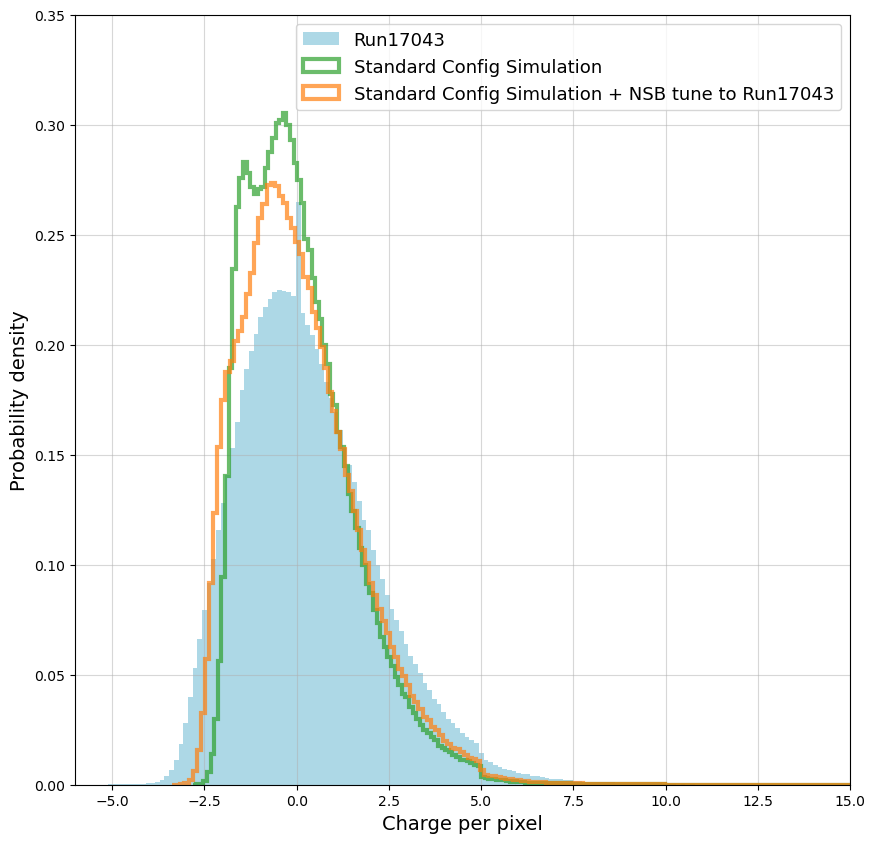

In [11]:
plt.figure(figsize=(10,10))

usefull_func.hist_wo_outliers(
    data_pixels_with_mask_0[:1855000], 
    label = 'Run17043', 
    density=True, 
    show_outliers=False, 
    outlier_value=30, 
    bins = 300, 
    color = 'lightblue', 
    alpha = 1)

# usefull_func.hist_wo_outliers(
#     official_sim_pixels_with_mask_0, 
#     label = 'Ruben config', 
#     density=True, 
#     mean_line=False, 
#     show_outliers=True, 
#     outlier_value=30, 
#     bins = 1855, 
#     color = colors[6], 
#     alpha = 0.5
# )

# usefull_func.hist_wo_outliers(
#     global_sim_pixels_with_mask_0, 
#     label = 'Standard Config', 
#     density=True, 
#     mean_line=False, 
#     show_outliers=True, 
#     outlier_value=30, 
#     bins = 300, 
#     color = colors[5], 
#     alpha = 1,
#     histtype = 'step', linewidth=2
# )

usefull_func.hist_wo_outliers(
    global_cor_sim_pixels_with_mask_0[:1855000], 
    label = 'Standard Config Simulation', 
    density=True, 
    mean_line=False, 
    show_outliers=True, 
    outlier_value=30, 
    bins = 300, 
    color = colors[2], 
    alpha = 0.7,
    histtype = 'step', linewidth=3
)

usefull_func.hist_wo_outliers(
    global_cor_nsbtune_sim_pixels_with_mask_0[:1855000], 
    label = 'Standard Config Simulation + NSB tune to Run17043', 
    density=True, 
    mean_line=False, 
    show_outliers=True, 
    outlier_value=30, 
    bins = 300, 
    color = colors[1], 
    alpha = 0.7,
    histtype = 'step', linewidth=3
)

plt.xlabel('Charge per pixel', fontsize = 14)
plt.ylabel('Probability density', fontsize = 14)
plt.ylim(0,0.35)
plt.xlim(-6,15)
#plt.title("Charge per pixel for pixels without signal")
plt.legend(prop={'size': 13})
#plt.savefig('/Users/vdk/muons2024/images/PlanPaper/dl1_hist_pixel_charge_no_signal_nsbtuned_clean.pdf', dpi=200, format='pdf', bbox_inches='tight')

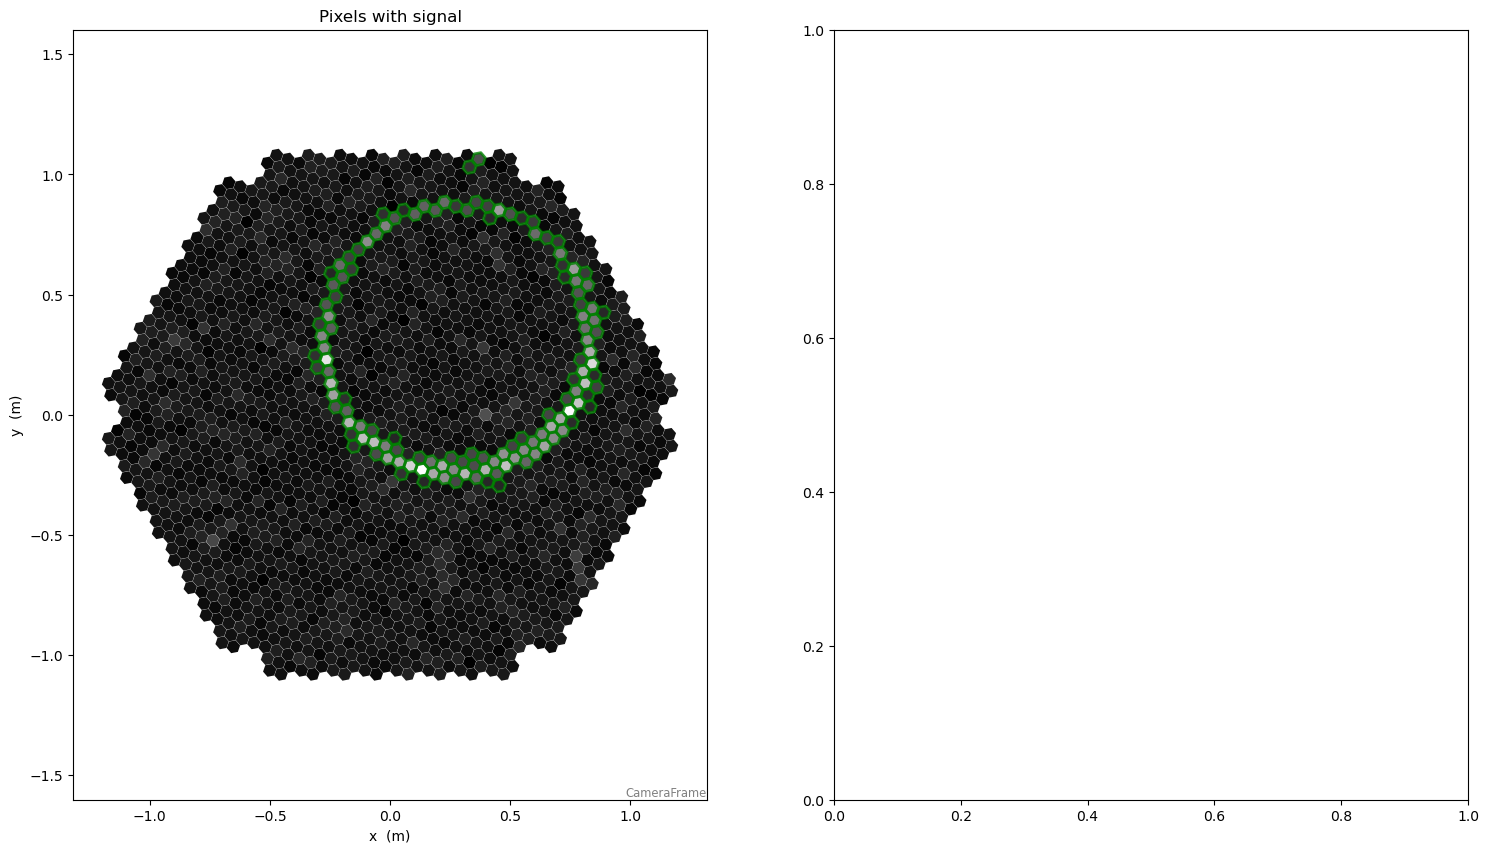

In [15]:

mask = tailcuts_clean(camgeom, data_dl1_images[2], picture_thresh=10, boundary_thresh=5)
fig, ax = plt.subplots(1, 2, figsize=(18, 10))
disp = CameraDisplay(
    camgeom, image=data_dl1_images[2], cmap="gray", ax = ax[0], title="Pixels with signal"
)
disp.highlight_pixels(mask, alpha=0.8, linewidth=2, color="green")

### Data for all years

In [3]:
muon_files = glob.glob('/Users/vdk/muons2024/all_muon_fits/low_nsb_filter/*')
print(sorted(muon_files))

df_files = [pd.read_csv(muon_file, na_values=['NA', '?']) for muon_file in sorted(muon_files)[2:]] 
df_all_data = pd.concat(df_files, ignore_index=True)
df_good_data_real = df_all_data[(df_all_data['muon_efficiency'] < 1) & (df_all_data['size_outside'] < 500)]
del(df_all_data)
df_good_data_real

['/Users/vdk/muons2024/all_muon_fits/low_nsb_filter/1_0-25k_lowNSBmuons.csv', '/Users/vdk/muons2024/all_muon_fits/low_nsb_filter/2_25-50k_lowNSBmuons.csv', '/Users/vdk/muons2024/all_muon_fits/low_nsb_filter/3_50-75k_lowNSBmuons.csv', '/Users/vdk/muons2024/all_muon_fits/low_nsb_filter/4_75-100k_lowNSBmuons.csv', '/Users/vdk/muons2024/all_muon_fits/low_nsb_filter/5_100-125k_lowNSBmuons.csv', '/Users/vdk/muons2024/all_muon_fits/low_nsb_filter/6_125-150k_lowNSBmuons.csv', '/Users/vdk/muons2024/all_muon_fits/low_nsb_filter/7_150-175k_lowNSBmuons.csv', '/Users/vdk/muons2024/all_muon_fits/low_nsb_filter/8_0-600fits_lowNSB.csv', '/Users/vdk/muons2024/all_muon_fits/low_nsb_filter/91_1200-1800fits_lowNSB.csv', '/Users/vdk/muons2024/all_muon_fits/low_nsb_filter/92_v010_1stHalf_lowNSB.csv', '/Users/vdk/muons2024/all_muon_fits/low_nsb_filter/93_v010_2ndHalf_lowNSB.csv', '/Users/vdk/muons2024/all_muon_fits/low_nsb_filter/9_600-1200fits_lowNSB.csv']


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_21144/3727673086.py:4: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_files = [pd.read_csv(muon_file, na_values=['NA', '?']) for muon_file in sorted(muon_files)[2:]]
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_21144/3727673086.py:4: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_files = [pd.read_csv(muon_file, na_values=['NA', '?']) for muon_file in sorted(muon_files)[2:]]
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_21144/3727673086.py:4: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_files = [pd.read_csv(muon_file, na_values=['NA', '?']) for muon_file in sorted(muon_files)[2:]]
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_21144/3727673086.py:4: DtypeWarning: Columns (9) have mixed types. Specify dtype option on i

,event_id,event_time,mc_energy,ring_size,size_outside,ring_center_x,ring_center_y,ring_radius,ring_width,good_ring,...,impact_parameter,impact_x_array,impact_y_array,radial_stdev,radial_skewness,radial_excess_kurtosis,num_pixels_in_ring,mean_pixel_charge_around_ring,hg_peak_sample,lg_peak_sample
0,586258.0,1.617941e+09,-1.0,1684.4609,0.000000,-1.126979,0.658542,0.922822,0.067606,1.0,...,6.861402,-6.243709,2.845159,0.061778,0.171984,-0.264917,285.0,0.419212,16.0,0.0
1,586524.0,1.617941e+09,-1.0,2396.6516,0.000000,0.414823,0.253566,1.077970,0.066451,1.0,...,2.454490,-0.975957,-2.252117,0.058575,-0.326664,0.455879,402.0,0.359592,16.0,0.0
2,586660.0,1.617941e+09,-1.0,2653.6575,0.000000,-0.773042,-0.405724,1.198359,0.043718,1.0,...,5.379249,-1.227168,5.237402,0.044159,0.428100,0.059450,498.0,0.448151,18.0,0.0
3,587473.0,1.617941e+09,-1.0,1995.5171,17.715633,-0.631950,-0.031935,0.923809,0.116068,1.0,...,4.493722,3.308376,-3.041084,0.094064,-0.362044,-0.075976,297.0,0.231521,16.0,0.0
4,591605.0,1.617941e+09,-1.0,1377.1779,6.083650,-0.046431,-1.123949,0.830340,0.078202,1.0,...,9.777186,1.409805,9.675010,0.070275,-0.385561,0.288797,239.0,0.200656,16.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24566563,5055075.0,1.674713e+09,-1.0,1242.5120,0.000000,-1.224233,2.159202,1.161522,0.080167,True,...,6.374878,-0.132690,6.373497,0.069734,-1.031511,0.640002,182.0,0.277134,10.0,0.0
24566564,5055159.0,1.674713e+09,-1.0,2182.8315,0.000000,0.045469,-0.660867,1.009607,0.071180,True,...,5.291778,5.289639,-0.150436,0.062548,-0.373700,0.266113,353.0,0.320824,10.0,0.0
24566565,5055180.0,1.674713e+09,-1.0,2119.8528,81.346530,0.501732,0.109346,0.891445,0.089546,True,...,5.857258,5.855136,-0.157671,0.092540,-0.898507,0.739353,274.0,0.804299,12.0,0.0
24566566,5056311.0,1.674713e+09,-1.0,1821.9410,6.692784,-0.431301,0.734208,0.981532,0.112360,True,...,9.194141,5.191974,-7.587862,0.091770,-0.250212,-0.288611,327.0,0.404962,12.0,0.0


### Ring size vs radius

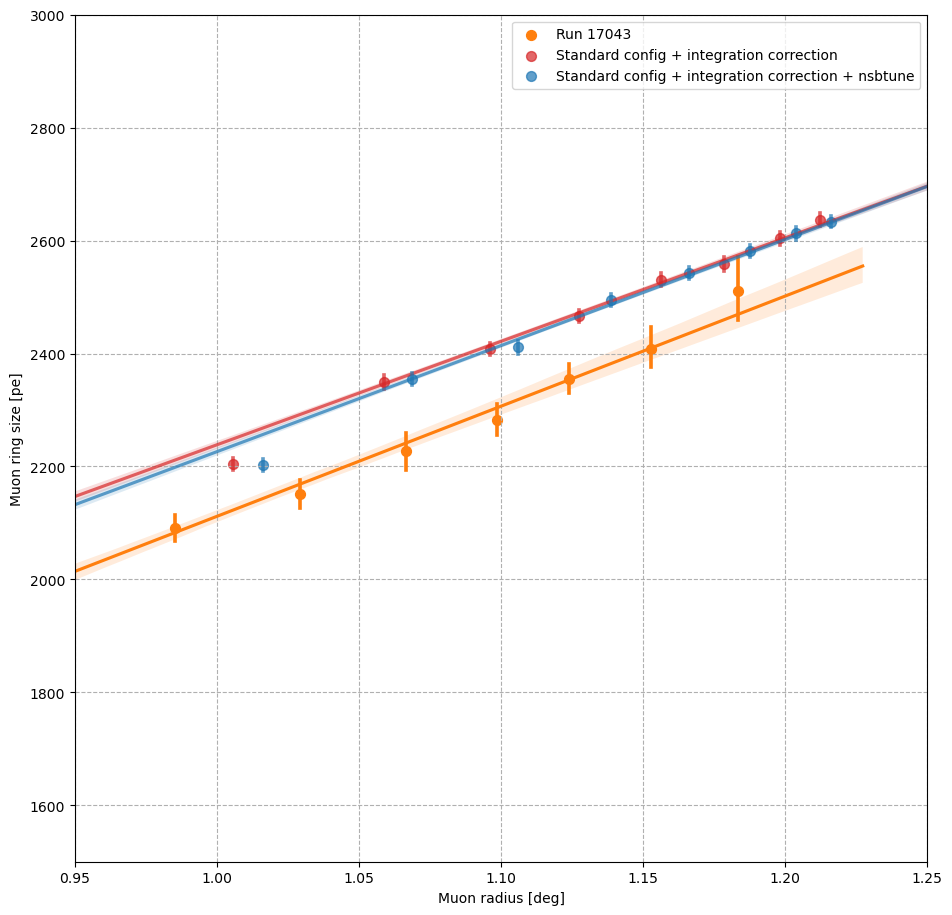

In [16]:
bin_number = 8
alpha_reg = 0.7
size_outside = 500

plt.figure(figsize = (11,11))

# sns.regplot(x = df_good_data_real['ring_radius'][(df_good_data_real['ring_completeness'] > ring_completeness_cut) & 
#                                                  (df_good_data_real['ring_containment'] > ring_containment_cut) & 
#                                                 (df_good_data_real['event_time'] > start_date_2021) &
#                                                 (df_good_data_real['event_time'] < end_date_2021)], 
#             y = df_good_data_real['ring_size'][(df_good_data_real['ring_completeness'] > ring_completeness_cut) &
#                                                (df_good_data_real['ring_containment'] > ring_containment_cut) &
#                                                 (df_good_data_real['event_time'] > start_date_2021) &
#                                                 (df_good_data_real['event_time'] < end_date_2021)], 
#             x_bins=bin_number, color=colors[0], label = 'Data for 2021 year')

# sns.regplot(x = df_good_data_real['ring_radius'][(df_good_data_real['ring_completeness'] > ring_completeness_cut) & 
#                                                  (df_good_data_real['ring_containment'] > ring_containment_cut) & 
#                                                 (df_good_data_real['event_time'] > start_date_2022) &
#                                                 (df_good_data_real['event_time'] < end_date_2022)], 
#             y = df_good_data_real['ring_size'][(df_good_data_real['ring_completeness'] > ring_completeness_cut) &
#                                                (df_good_data_real['ring_containment'] > ring_containment_cut) &
#                                                 (df_good_data_real['event_time'] > start_date_2022) &
#                                                 (df_good_data_real['event_time'] < end_date_2022)], 
#             x_bins=bin_number, color=colors[1], label = 'Data for 2022 year')

# sns.regplot(x = df_good_data_real['ring_radius'][(df_good_data_real['ring_completeness'] > ring_completeness_cut) & 
#                                                  (df_good_data_real['ring_containment'] > ring_containment_cut) & 
#                                                 (df_good_data_real['event_time'] > start_date_2023) &
#                                                 (df_good_data_real['event_time'] < end_date_2023)], 
#             y = df_good_data_real['ring_size'][(df_good_data_real['ring_completeness'] > ring_completeness_cut) &
#                                                (df_good_data_real['ring_containment'] > ring_containment_cut) &  
#                                                 (df_good_data_real['event_time'] > start_date_2023) &
#                                                 (df_good_data_real['event_time'] < end_date_2023)], 
#             x_bins=bin_number, color=colors[2], label = 'Data for 2023 year')

# sns.regplot(x = df_good_data_real['ring_radius'][(df_good_data_real['ring_completeness'] > ring_completeness_cut) & 
#                                                  (df_good_data_real['ring_containment'] > ring_containment_cut) & 
#                                                 (df_good_data_real['event_time'] > start_date_2024) &
#                                                 (df_good_data_real['event_time'] < end_date_2024)], 
#             y = df_good_data_real['ring_size'][(df_good_data_real['ring_completeness'] > ring_completeness_cut) &
#                                                (df_good_data_real['ring_containment'] > ring_containment_cut) &  
#                                                 (df_good_data_real['event_time'] > start_date_2024) &
#                                                 (df_good_data_real['event_time'] < end_date_2024)], 
#             x_bins=bin_number, color=colors[1], label = 'Data for 2024 year')

sns.regplot(x = df_real_data['ring_radius'][(df_real_data['size_outside'] < size_outside)],
            y = df_real_data['ring_size'][(df_real_data['size_outside'] < size_outside)],
            x_bins=bin_number, color=colors[1], label = 'Run 17043')


#sns.regplot(x = df_sim_data_official['ring_radius'], y = df_sim_data_official['ring_size'], x_bins=bin_number, color='k', label = 'Ruben config', scatter_kws={'alpha': alpha_reg}, line_kws={'alpha': alpha_reg})
#sns.regplot(x = df_sim_data_official_tailcuts84['ring_radius'], y = df_sim_data_official_tailcuts84['ring_size'], x_bins=bin_number, color='g', label = 'Ruben config tailcuts84', scatter_kws={'alpha': alpha_reg}, line_kws={'alpha': alpha_reg})
#sns.regplot(x = df_sim_data_global['ring_radius'], y = df_sim_data_global['ring_size'], x_bins=bin_number, color=colors[4], label = 'Standard config', scatter_kws={'alpha': alpha_reg}, line_kws={'alpha': alpha_reg})
sns.regplot(x = df_sim_data_global_integration_cor['ring_radius'], y = df_sim_data_global_integration_cor['ring_size'], x_bins=bin_number, color=colors[3], label = 'Standard config + integration correction', scatter_kws={'alpha': alpha_reg}, line_kws={'alpha': alpha_reg})
sns.regplot(x = df_sim_data_global_integration_cor_nsbtune['ring_radius'], y = df_sim_data_global_integration_cor_nsbtune['ring_size'], x_bins=bin_number, color=colors[0], label = 'Standard config + integration correction + nsbtune', scatter_kws={'alpha': alpha_reg}, line_kws={'alpha': alpha_reg})
#sns.regplot(x = df_real_cut['ring_radius'], y = df_real_cut['ring_size'], x_bins=bin_number, color=colors[0], label = '2024 data', scatter_kws={'alpha': alpha_reg}, line_kws={'alpha': alpha_reg})
#sns.regplot(x = df_sim_cut['ring_radius'], y = df_sim_cut['ring_size'], x_bins=bin_number, color=colors[1], label = 'Standard config + nsbtune', scatter_kws={'alpha': alpha_reg}, line_kws={'alpha': alpha_reg})
#sns.regplot(x = df_sim_data_global_integration_cor_nsbtune_04R['ring_radius'], y = df_sim_data_global_integration_cor_nsbtune_04R['ring_size'], x_bins=bin_number, color=colors[2], label = 'Standard config + integration correction + nsbtune+0125R', scatter_kws={'alpha': alpha_reg}, line_kws={'alpha': alpha_reg})

#sns.regplot(x = df_sim_data_globa_nsbtune['ring_radius'], y = df_sim_data_globa_nsbtune['ring_size'], x_bins=bin_number, color=colors[5], label = 'Standard Config + NSBTune + mirror_degraded_reflection 0.9016', scatter_kws={'alpha': alpha_reg}, line_kws={'alpha': alpha_reg})
#sns.regplot(x = df_sim_data_georgios_standard['ring_radius'], y = df_sim_data_georgios_standard['ring_size'], x_bins=bin_number, color=colors[5], label = 'Georgios + Standard config', scatter_kws={'alpha': alpha_reg}, line_kws={'alpha': alpha_reg})

plt.xlabel('Muon radius [deg]')
plt.ylabel('Muon ring size [pe]')
plt.grid(linestyle="dashed")
plt.ylim(1500,3000)
plt.xlim(0.95,1.25)
plt.legend(prop={'size': 10})
#plt.savefig('/Users/vdk/muons2024/images/PlanPaper/mcdata_size_2023-24year_allreflections.pdf', dpi=200, format='pdf', bbox_inches='tight')

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_8839/397594196.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mc['binned_radius'] = pd.cut(data_mc['ring_radius'], bins, include_lowest=True, labels=False)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_8839/397594196.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_run['binned_radius'] = pd.cut(data_run['ring_radius'], bins, include_lowest=True, labels=False)


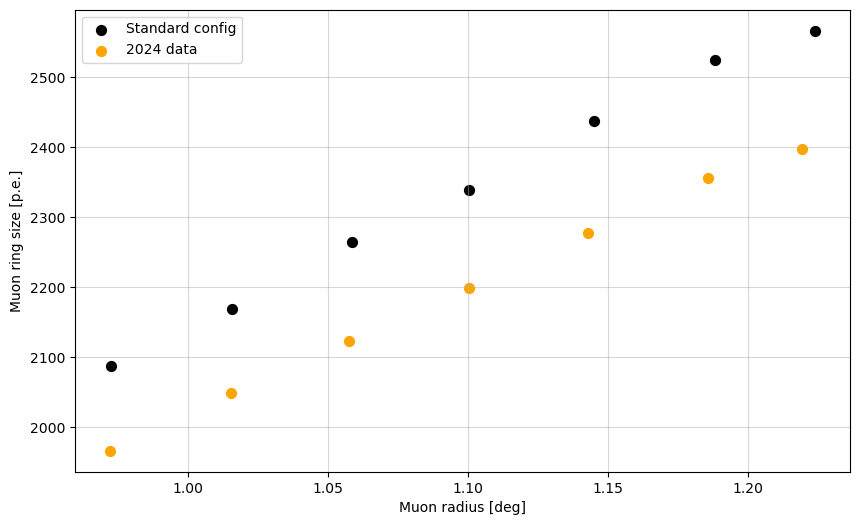

In [20]:
# ring_completeness_cut = 0.9
# ring_containment_cut = 0.9
df_real_data_cut = df_good_data_real[(df_good_data_real['ring_completeness'] > ring_completeness_cut) &
                                     (df_good_data_real['ring_containment'] > ring_containment_cut) &  
                                     (df_good_data_real['event_time'] > start_date_2024) &
                                     (df_good_data_real['event_time'] < end_date_2024)
                                     ]

df_sim_cut = df_sim_data_global_integration_cor_nsbtune[
    (df_sim_data_global_integration_cor_nsbtune['ring_radius'] > 0.95) & 
    (df_sim_data_global_integration_cor_nsbtune['ring_radius'] < 1.25)
    ]
df_real_cut = df_real_data_cut[(df_real_data_cut['ring_radius'] > 0.95) & (df_real_data_cut['ring_radius'] < 1.25)]
#df_real_cut = df_real_data_2973[(df_real_data_2973['ring_radius'] > 0.95) & (df_real_data_2973['ring_radius'] < 1.25)]

data_mc = df_sim_cut

data_run = df_real_cut
# Define the bin edges
bins = np.linspace(0.95, 1.25, 8)  # Adjust the number of bins as needed

# Bin the data for MC
data_mc['binned_radius'] = pd.cut(data_mc['ring_radius'], bins, include_lowest=True, labels=False)
binned_mc = data_mc.groupby('binned_radius').agg({
    'ring_radius': 'mean',
    'ring_size': 'mean'
})

# Bin the data for Run
data_run['binned_radius'] = pd.cut(data_run['ring_radius'], bins, include_lowest=True, labels=False)
binned_run = data_run.groupby('binned_radius').agg({
    'ring_radius': 'mean',
    'ring_size': 'mean'
})

# Plotting
plt.figure(figsize=(10, 6))

# Plotting MC data
plt.scatter(binned_mc['ring_radius'], binned_mc['ring_size'], color='k', label='Standard config', s = 50)

# Plotting Data Run
plt.scatter(binned_run['ring_radius'], binned_run['ring_size'], color='orange', label='2024 data', s = 50)

# Adding labels and legend
plt.xlabel('Muon radius [deg]')
plt.ylabel('Muon ring size [p.e.]')
plt.legend()
plt.grid(alpha = 0.5)
plt.show()

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_21144/2898736538.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mc['binned_radius'] = pd.cut(data_mc['ring_radius'], bins, include_lowest=True, labels=False)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_21144/2898736538.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_run['binned_radius'] = pd.cut(data_run['ring_radius'], bins, include_lowest=True, labels=False)


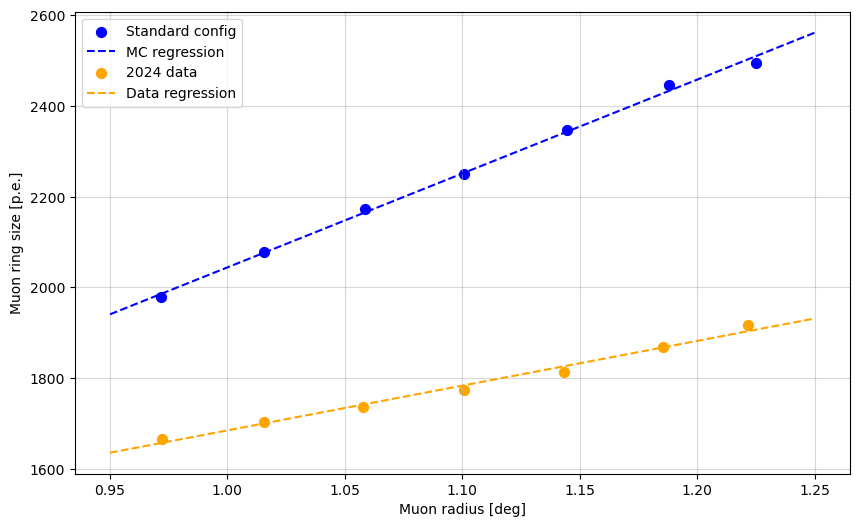

In [6]:
# df_real_data_cut = df_good_data_real[
#     (df_good_data_real['ring_completeness'] > ring_completeness_cut) &
#     (df_good_data_real['ring_containment'] > ring_containment_cut) &  
#     (df_good_data_real['ring_radius'] > 0.95) &  
#     (df_good_data_real['ring_radius'] < 1.25) &  
#     (df_good_data_real['event_time'] > start_date_2024) &
#     (df_good_data_real['event_time'] < end_date_2024)
# ]


df_real_data_cut = df_good_data_real[ 
    (df_good_data_real['ring_radius'] > 0.95) &  
    (df_good_data_real['ring_radius'] < 1.25) &  
    (df_good_data_real['event_time'] > start_date_2024) &
    (df_good_data_real['event_time'] < end_date_2024)
]

df_sim_cut = df_sim_data_global_integration_cor_nsbtune[
    (df_sim_data_global_integration_cor_nsbtune['ring_radius'] > 0.95) & 
    (df_sim_data_global_integration_cor_nsbtune['ring_radius'] < 1.25)
]

data_mc = df_sim_cut

data_run = df_real_data_cut
# Define the bins
bins = np.linspace(0.95, 1.25, 8)  # Adjust the number of bins as needed

# Bin the data for MC
data_mc['binned_radius'] = pd.cut(data_mc['ring_radius'], bins, include_lowest=True, labels=False)
binned_mc = data_mc.groupby('binned_radius').agg({
    'ring_radius': 'mean',
    'ring_size': 'mean'
})

# Bin the data for Run
data_run['binned_radius'] = pd.cut(data_run['ring_radius'], bins, include_lowest=True, labels=False)
binned_run = data_run.groupby('binned_radius').agg({
    'ring_radius': 'mean',
    'ring_size': 'mean'
})

binned_mc['ring_size'] = binned_mc['ring_size']

# Perform linear regression
mc_slope, mc_intercept = np.polyfit(binned_mc['ring_radius'], binned_mc['ring_size'], 1)
run_slope, run_intercept = np.polyfit(binned_run['ring_radius'], binned_run['ring_size'], 1)

# Generate x values for the regression lines
x_values = np.linspace(bins.min(), bins.max(), 300)

# Generate y values using the regression parameters
y_values_mc = mc_slope * x_values + mc_intercept
y_values_run = run_slope * x_values + run_intercept

# Plotting
plt.figure(figsize=(10, 6))

# Plotting MC data
plt.scatter(binned_mc['ring_radius'], binned_mc['ring_size'], color='blue', label='Standard config', s=50)
plt.plot(x_values, y_values_mc, color='blue', linestyle='--', label='MC regression')

# Plotting Data Run
plt.scatter(binned_run['ring_radius'], binned_run['ring_size'], color='orange', label='2024 data', s=50)
plt.plot(x_values, y_values_run, color='orange', linestyle='--', label='Data regression')

# Adding labels and legend
plt.xlabel('Muon radius [deg]')
plt.ylabel('Muon ring size [p.e.]')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_11623/2825378973.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sim_data_global_integration_cor_nsbtune_ref0736_cut['binned_radius'] = pd.cut(


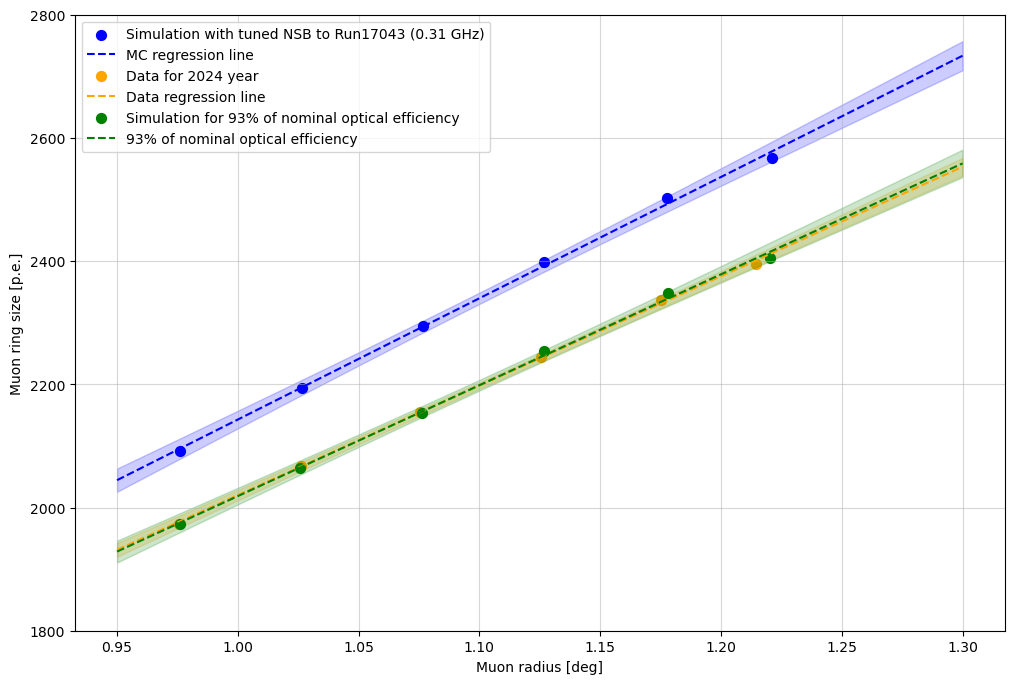

In [64]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Filter df_sim_data_global_integration_cor_nsbtune_ref0736
df_sim_data_global_integration_cor_nsbtune_ref0736_cut = df_sim_data_global_integration_cor_nsbtune_ref0736[
    (df_sim_data_global_integration_cor_nsbtune_ref0736['ring_radius'] > 0.95) & 
    (df_sim_data_global_integration_cor_nsbtune_ref0736['ring_radius'] < 1.25)
]

# Bin the data for df_sim_data_global_integration_cor_nsbtune_ref0736
df_sim_data_global_integration_cor_nsbtune_ref0736_cut['binned_radius'] = pd.cut(
    df_sim_data_global_integration_cor_nsbtune_ref0736_cut['ring_radius'], bins, include_lowest=True, labels=False
)
binned_sim_ref = df_sim_data_global_integration_cor_nsbtune_ref0736_cut.groupby('binned_radius').agg({
    'ring_radius': 'mean',
    'ring_size': 'mean'
})
binned_sim_ref['ring_size'] = binned_sim_ref['ring_size'] * 0.995
# Add a constant to the independent variable for statsmodels
binned_sim_ref['constant'] = 1

# Perform linear regression using statsmodels
model_sim_ref = sm.OLS(binned_sim_ref['ring_size'], binned_sim_ref[['constant', 'ring_radius']]).fit()

# Generate y values and confidence intervals using the regression models
y_values_sim_ref = model_sim_ref.predict(x_values_with_const)
prediction_sim_ref = model_sim_ref.get_prediction(x_values_with_const)
conf_int_sim_ref = prediction_sim_ref.conf_int()

# Plotting
plt.figure(figsize=(12, 8))

# Plotting MC data
plt.scatter(binned_mc['ring_radius'], binned_mc['ring_size'], color='blue', label='Simulation with tuned NSB to Run17043 (0.31 GHz)', s=50)
plt.plot(x_values, y_values_mc, color='blue', linestyle='--', label='MC regression line')
plt.fill_between(x_values, conf_int_mc[:, 0], conf_int_mc[:, 1], color='blue', alpha=0.2)

# Plotting Data Run
plt.scatter(binned_run['ring_radius'], binned_run['ring_size'], color='orange', label='Data for 2024 year', s=50)
plt.plot(x_values, y_values_run, color='orange', linestyle='--', label='Data regression line')
plt.fill_between(x_values, conf_int_run[:, 0], conf_int_run[:, 1], color='orange', alpha=0.2)

# Plotting Sim Ref Data
plt.scatter(binned_sim_ref['ring_radius'], binned_sim_ref['ring_size'], color='green', label='Simulation for 93% of nominal optical efficiency', s=50)
plt.plot(x_values, y_values_sim_ref, color='green', linestyle='--', label='93% of nominal optical efficiency')
plt.fill_between(x_values, conf_int_sim_ref[:, 0], conf_int_sim_ref[:, 1], color='green', alpha=0.2)

# Adding labels and legend
plt.xlabel('Muon radius [deg]')
plt.ylabel('Muon ring size [p.e.]')
plt.legend()
plt.ylim(1800,2800)
plt.grid(alpha=0.5)
#plt.show()
#plt.savefig('/Users/vdk/muons2024/images/PlanPaper/latest_config_size_vs_radius_2024year_reflection-7percent.pdf', dpi=200, format='pdf', bbox_inches='tight')

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_11623/3836233103.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mc['binned_radius'] = pd.cut(data_mc['ring_radius'], bins, include_lowest=True, labels=False)


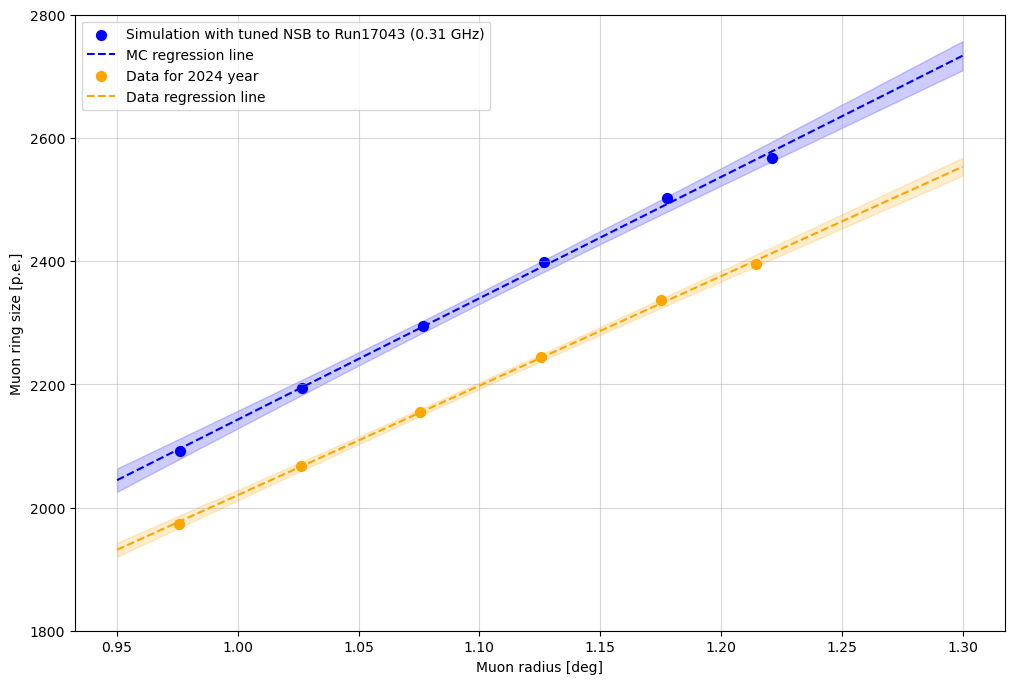

In [63]:
df_real_data_cut = df_good_data_real[(df_good_data_real['ring_completeness'] > ring_completeness_cut) &
                                     (df_good_data_real['ring_containment'] > ring_containment_cut) & 
                                     (df_good_data_real['ring_radius'] > 0.95) & 
                                     (df_good_data_real['ring_radius'] < 1.25) &
                                     (df_good_data_real['event_time'] > start_date_2024) &
                                     (df_good_data_real['event_time'] < end_date_2024)
                                     ]

df_sim_cut = df_sim_data_global_integration_cor_nsbtune[
    (df_sim_data_global_integration_cor_nsbtune['ring_radius'] > 0.95) & 
    (df_sim_data_global_integration_cor_nsbtune['ring_radius'] < 1.25)
    ]
df_real_cut = df_real_data_cut[(df_real_data_cut['ring_radius'] > 0.95) & (df_real_data_cut['ring_radius'] < 1.25)]
#df_real_cut = df_real_data_2973[(df_real_data_2973['ring_radius'] > 0.95) & (df_real_data_2973['ring_radius'] < 1.25)]

data_mc = df_sim_cut

data_run = df_real_cut
# Define the bins
bins = np.linspace(0.95, 1.3, 8)  # Adjust the number of bins as needed

# Bin the data for MC
data_mc['binned_radius'] = pd.cut(data_mc['ring_radius'], bins, include_lowest=True, labels=False)
binned_mc = data_mc.groupby('binned_radius').agg({
    'ring_radius': 'mean',
    'ring_size': 'mean'
})

# Bin the data for Run
data_run['binned_radius'] = pd.cut(data_run['ring_radius'], bins, include_lowest=True, labels=False)
binned_run = data_run.groupby('binned_radius').agg({
    'ring_radius': 'mean',
    'ring_size': 'mean'
})

binned_mc['ring_size'] = binned_mc['ring_size']

# Add a constant to the independent variable for statsmodels
binned_mc['constant'] = 1
binned_run['constant'] = 1

# Perform linear regression using statsmodels
model_mc = sm.OLS(binned_mc['ring_size'], binned_mc[['constant', 'ring_radius']]).fit()
model_run = sm.OLS(binned_run['ring_size'], binned_run[['constant', 'ring_radius']]).fit()

# Generate x values for the regression lines
x_values = np.linspace(bins.min(), bins.max(), 300)
x_values_with_const = sm.add_constant(x_values)

# Generate y values and confidence intervals using the regression models
y_values_mc = model_mc.predict(x_values_with_const)
prediction_mc = model_mc.get_prediction(x_values_with_const)
conf_int_mc = prediction_mc.conf_int()

y_values_run = model_run.predict(x_values_with_const)
prediction_run = model_run.get_prediction(x_values_with_const)
conf_int_run = prediction_run.conf_int()

# Plotting
plt.figure(figsize=(12, 8))

# Plotting MC data
plt.scatter(binned_mc['ring_radius'], binned_mc['ring_size'], color='blue', label='Simulation with tuned NSB to Run17043 (0.31 GHz)', s=50)
plt.plot(x_values, y_values_mc, color='blue', linestyle='--', label='MC regression line')
plt.fill_between(x_values, conf_int_mc[:, 0], conf_int_mc[:, 1], color='blue', alpha=0.2)

# Plotting Data Run
plt.scatter(binned_run['ring_radius'], binned_run['ring_size'], color='orange', label='Data for 2024 year', s=50)
plt.plot(x_values, y_values_run, color='orange', linestyle='--', label='Data regression line')
plt.fill_between(x_values, conf_int_run[:, 0], conf_int_run[:, 1], color='orange', alpha=0.2)

# Adding labels and legend
plt.xlabel('Muon radius [deg]')
plt.ylabel('Muon ring size [p.e.]')
plt.legend()
plt.ylim(1800,2800)
plt.grid(alpha=0.5)
#plt.show()
#plt.savefig('/Users/vdk/muons2024/images/PlanPaper/latest_config_size_vs_radius_2024year_reflection_v2.pdf', dpi=200, format='pdf', bbox_inches='tight')

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_21144/4184898148.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real_data_cut['binned_radius'] = pd.cut(df_real_data_cut['ring_radius'], bins, include_lowest=True, labels=False)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_21144/4184898148.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real_data_cut['binned_radius'] = pd.cut(df_real_data_cut['ring_radius'], bins, include_lowest=True, labels=False)
/var/folders/_p/3fmt

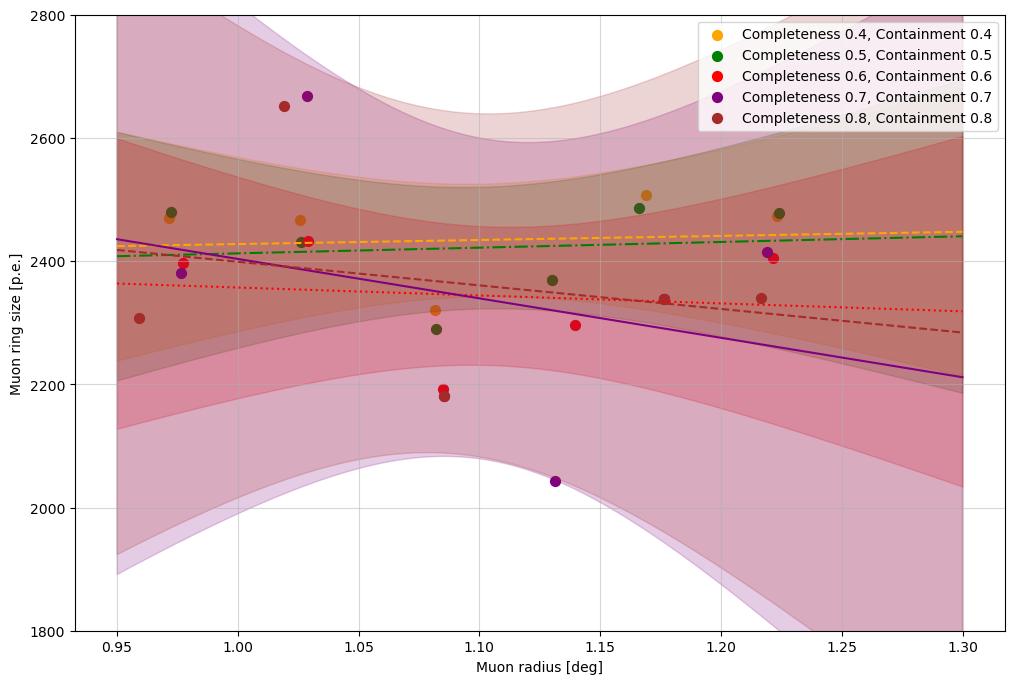

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Define a function to perform the filtering and plotting for different cuts
def filter_and_plot(df_real_data, ring_completeness_cut, ring_containment_cut, color, linestyle):
    df_real_data_cut = df_real_data[
        (df_real_data['ring_completeness'] > ring_completeness_cut) &
        (df_real_data['ring_containment'] > ring_containment_cut) & 
        (df_real_data['ring_radius'] > 0.95) & 
        (df_real_data['ring_radius'] < 1.25)
    ]
    
    # Bin the data for Run
    df_real_data_cut['binned_radius'] = pd.cut(df_real_data_cut['ring_radius'], bins, include_lowest=True, labels=False)
    binned_run = df_real_data_cut.groupby('binned_radius').agg({
        'ring_radius': 'mean',
        'ring_size': 'mean'
    })

    # Perform linear regression using statsmodels
    binned_run['constant'] = 1
    model_run = sm.OLS(binned_run['ring_size'], binned_run[['constant', 'ring_radius']]).fit()

    # Generate y values and confidence intervals using the regression models
    y_values_run = model_run.predict(x_values_with_const)
    prediction_run = model_run.get_prediction(x_values_with_const)
    conf_int_run = prediction_run.conf_int()

    # Plotting Data Run
    plt.scatter(binned_run['ring_radius'], binned_run['ring_size'], color=color, label=f'Completeness {ring_completeness_cut}, Containment {ring_containment_cut}', s=50)
    plt.plot(x_values, y_values_run, color=color, linestyle=linestyle)
    plt.fill_between(x_values, conf_int_run[:, 0], conf_int_run[:, 1], color=color, alpha=0.2)

# Define the bins
bins = np.linspace(0.95, 1.3, 8)  # Adjust the number of bins as needed



plt.figure(figsize=(12, 8))

# Colors and linestyles for different cuts
colors = ['orange', 'green', 'red', 'purple', 'brown']
linestyles = ['--', '-.', ':', '-', '--']

# Plot data for different cuts
cuts = [0.4, 0.5, 0.6, 0.7, 0.8]
for i, cut in enumerate(cuts):
    filter_and_plot(df_real_data, cut, cut, colors[i], linestyles[i])

# Adding labels and legend
plt.xlabel('Muon radius [deg]')
plt.ylabel('Muon ring size [p.e.]')
plt.ylim(1800, 2800)
plt.legend()
plt.grid(alpha=0.5)
plt.show()

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_11623/2048257884.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mc['binned_radius'] = pd.cut(data_mc['ring_radius'], bins, include_lowest=True, labels=False)


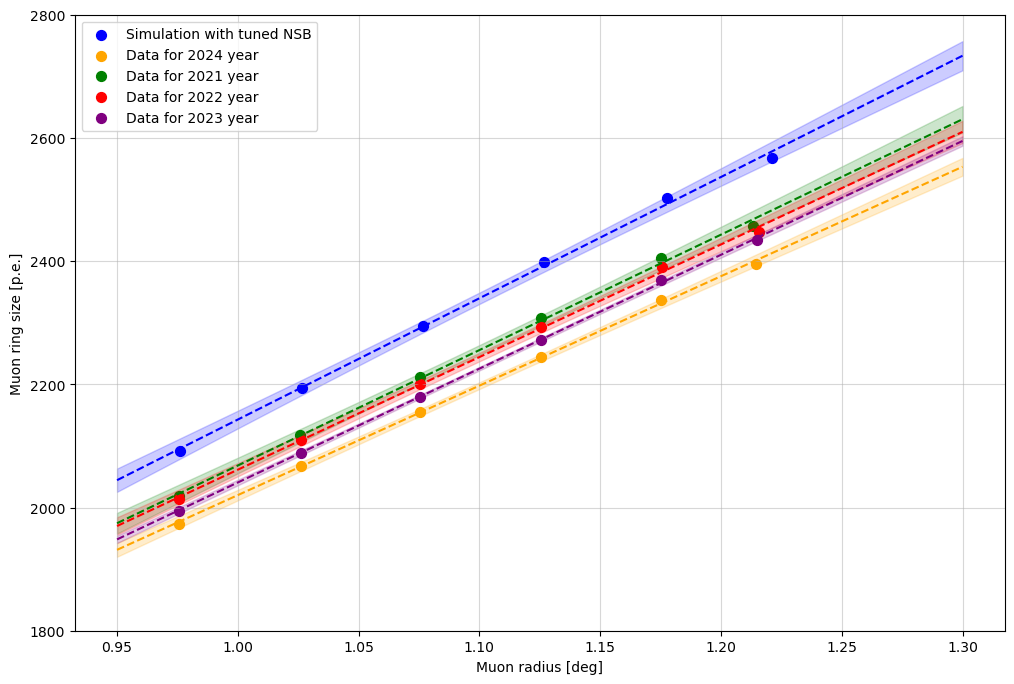

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Define a function to perform the filtering and plotting for a given year
def filter_and_plot(df_real_data, start_date, end_date, label, color):
    df_real_data_cut = df_real_data[
        (df_real_data['ring_completeness'] > ring_completeness_cut) &
        (df_real_data['ring_containment'] > ring_containment_cut) & 
        (df_real_data['ring_radius'] > 0.95) & 
        (df_real_data['ring_radius'] < 1.25) &
        (df_real_data['event_time'] > start_date) &
        (df_real_data['event_time'] < end_date)
    ]
    
    df_real_cut = df_real_data_cut[(df_real_data_cut['ring_radius'] > 0.95) & (df_real_data_cut['ring_radius'] < 1.25)]
    
    # Bin the data for Run
    df_real_cut['binned_radius'] = pd.cut(df_real_cut['ring_radius'], bins, include_lowest=True, labels=False)
    binned_run = df_real_cut.groupby('binned_radius').agg({
        'ring_radius': 'mean',
        'ring_size': 'mean'
    })

    # Perform linear regression using statsmodels
    binned_run['constant'] = 1
    model_run = sm.OLS(binned_run['ring_size'], binned_run[['constant', 'ring_radius']]).fit()

    # Generate y values and confidence intervals using the regression models
    y_values_run = model_run.predict(x_values_with_const)
    prediction_run = model_run.get_prediction(x_values_with_const)
    conf_int_run = prediction_run.conf_int()

    # Plotting Data Run
    plt.scatter(binned_run['ring_radius'], binned_run['ring_size'], color=color, label=label, s=50)
    plt.plot(x_values, y_values_run, color=color, linestyle='--')
    plt.fill_between(x_values, conf_int_run[:, 0], conf_int_run[:, 1], color=color, alpha=0.2)

# Define the bins
bins = np.linspace(0.95, 1.3, 8)  # Adjust the number of bins as needed

# Bin the data for MC
data_mc['binned_radius'] = pd.cut(data_mc['ring_radius'], bins, include_lowest=True, labels=False)
binned_mc = data_mc.groupby('binned_radius').agg({
    'ring_radius': 'mean',
    'ring_size': 'mean'
})

# Perform linear regression using statsmodels
binned_mc['constant'] = 1
model_mc = sm.OLS(binned_mc['ring_size'], binned_mc[['constant', 'ring_radius']]).fit()

# Generate x values for the regression lines
x_values = np.linspace(bins.min(), bins.max(), 300)
x_values_with_const = sm.add_constant(x_values)

# Generate y values and confidence intervals using the regression models
y_values_mc = model_mc.predict(x_values_with_const)
prediction_mc = model_mc.get_prediction(x_values_with_const)
conf_int_mc = prediction_mc.conf_int()

# Plotting
plt.figure(figsize=(12, 8))

# Plotting MC data
plt.scatter(binned_mc['ring_radius'], binned_mc['ring_size'], color='blue', label='Simulation with tuned NSB', s=50)
plt.plot(x_values, y_values_mc, color='blue', linestyle='--')
plt.fill_between(x_values, conf_int_mc[:, 0], conf_int_mc[:, 1], color='blue', alpha=0.2)

# Plot data for each year
filter_and_plot(df_good_data_real, start_date_2024, end_date_2024, 'Data for 2024 year', 'orange')
filter_and_plot(df_good_data_real, start_date_2021, end_date_2021, 'Data for 2021 year', 'green')
filter_and_plot(df_good_data_real, start_date_2022, end_date_2022, 'Data for 2022 year', 'red')
filter_and_plot(df_good_data_real, start_date_2023, end_date_2023, 'Data for 2023 year', 'purple')

# Adding labels and legend
plt.xlabel('Muon radius [deg]')
plt.ylabel('Muon ring size [p.e.]')
plt.ylim(1800,2800)
plt.legend()
plt.grid(alpha=0.5)
plt.show()
#plt.savefig('/Users/vdk/muons2024/images/PlanPaper/latest_config_size_vs_radius_all_years.pdf', dpi=200, format='pdf', bbox_inches='tight')

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_21144/1511412720.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real_data_cut['binned_radius'] = pd.cut(df_real_data_cut['ring_radius'], bins, include_lowest=True, labels=False)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_21144/1511412720.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real_data_cut['binned_radius'] = pd.cut(df_real_data_cut['ring_radius'], bins, include_lowest=True, labels=False)
/var/folders/_p/3fmt

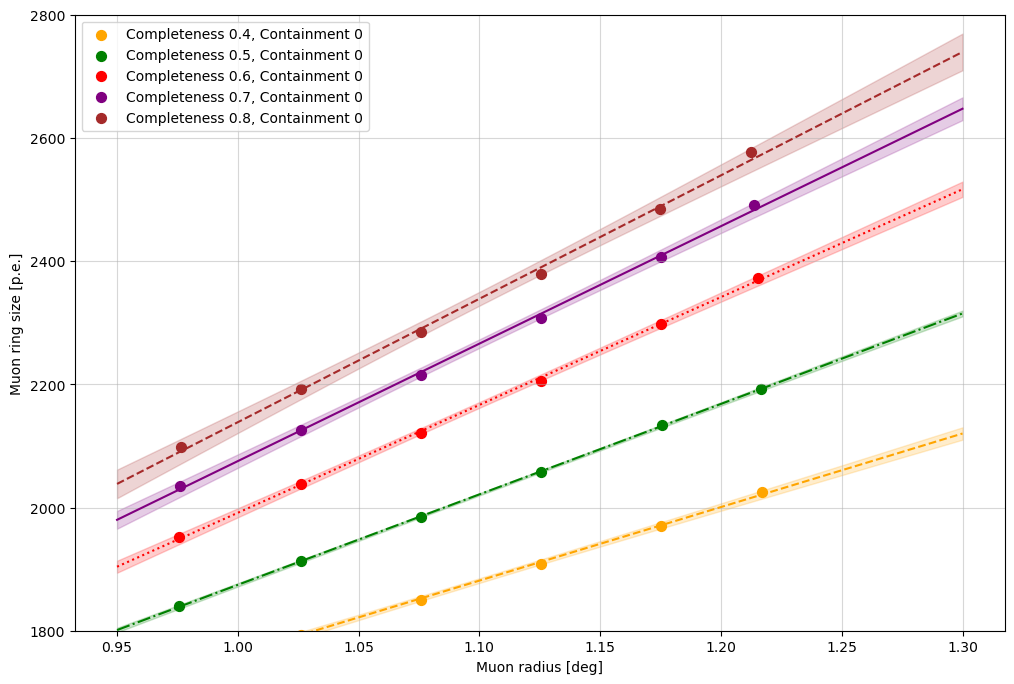

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Define a function to perform the filtering and plotting for different cuts
def filter_and_plot(df_real_data, ring_completeness_cut, ring_containment_cut, color, linestyle):
    df_real_data_cut = df_real_data[
        (df_real_data['ring_completeness'] > ring_completeness_cut) &
        (df_real_data['ring_containment'] > ring_containment_cut) & 
        (df_real_data['ring_radius'] > 0.95) & 
        (df_real_data['ring_radius'] < 1.25)
    ]
    
    # Bin the data for Run
    df_real_data_cut['binned_radius'] = pd.cut(df_real_data_cut['ring_radius'], bins, include_lowest=True, labels=False)
    binned_run = df_real_data_cut.groupby('binned_radius').agg({
        'ring_radius': 'mean',
        'ring_size': 'mean'
    })

    # Perform linear regression using statsmodels
    binned_run['constant'] = 1
    model_run = sm.OLS(binned_run['ring_size'], binned_run[['constant', 'ring_radius']]).fit()

    # Generate y values and confidence intervals using the regression models
    y_values_run = model_run.predict(x_values_with_const)
    prediction_run = model_run.get_prediction(x_values_with_const)
    conf_int_run = prediction_run.conf_int()

    # Plotting Data Run
    plt.scatter(binned_run['ring_radius'], binned_run['ring_size'], color=color, label=f'Completeness {ring_completeness_cut}, Containment {ring_containment_cut}', s=50)
    plt.plot(x_values, y_values_run, color=color, linestyle=linestyle)
    plt.fill_between(x_values, conf_int_run[:, 0], conf_int_run[:, 1], color=color, alpha=0.2)

# Define the bins
bins = np.linspace(0.95, 1.3, 8)  # Adjust the number of bins as needed





# Generate x values for the regression lines
x_values = np.linspace(bins.min(), bins.max(), 300)
x_values_with_const = sm.add_constant(x_values)

# Generate y values and confidence intervals using the regression models
y_values_mc = model_mc.predict(x_values_with_const)
prediction_mc = model_mc.get_prediction(x_values_with_const)
conf_int_mc = prediction_mc.conf_int()


# Define start and end dates for filtering
start_date_2024 = '2024-01-01'
end_date_2024 = '2024-12-31'

# Plotting
plt.figure(figsize=(12, 8))

# Plotting MC data


# Colors and linestyles for different cuts
colors = ['orange', 'green', 'red', 'purple', 'brown']
linestyles = ['--', '-.', ':', '-', '--']

# Plot data for different cuts
for i, (ring_completeness_cut, ring_containment_cut) in enumerate(zip([0.4, 0.5, 0.6, 0.7, 0.8], [0, 0, 0, 0, 0])):
    filter_and_plot(df_good_data_real, ring_completeness_cut, ring_containment_cut, colors[i], linestyles[i])

# Adding labels and legend
plt.xlabel('Muon radius [deg]')
plt.ylabel('Muon ring size [p.e.]')
plt.ylim(1800, 2800)
plt.legend()
plt.grid(alpha=0.5)
plt.show()

In [58]:
df_good_data_real

: 

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_11623/3995562896.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mc['binned_radius'] = pd.cut(data_mc['ring_radius'], bins, include_lowest=True, labels=False)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_11623/3995562896.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_run['binned_radius'] = pd.cut(data_run['ring_radius'], bins, include_lowest=True, labels=False)


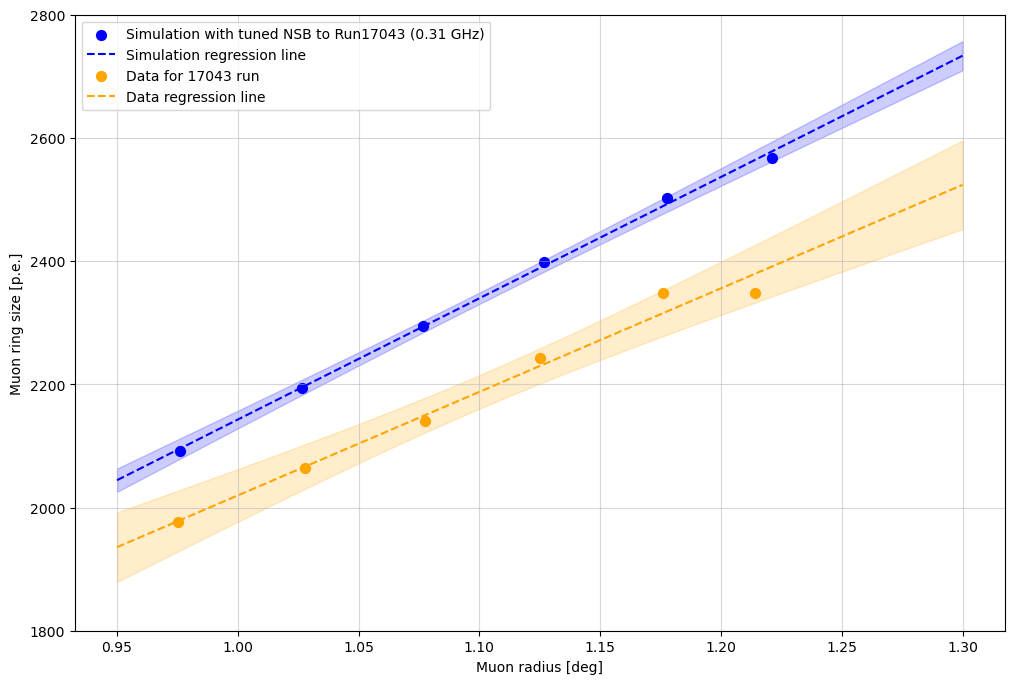

In [62]:
df_real_data_cut = df_real_data_17043[(df_real_data_17043['ring_completeness'] > ring_completeness_cut) &
                                     (df_real_data_17043['ring_containment'] > ring_containment_cut) &
                                     (df_real_data_17043['ring_radius'] > 0.95) & 
                                     (df_real_data_17043['ring_radius'] < 1.25)]

df_sim_cut = df_sim_data_global_integration_cor_nsbtune[
    (df_sim_data_global_integration_cor_nsbtune['ring_radius'] > 0.95) & 
    (df_sim_data_global_integration_cor_nsbtune['ring_radius'] < 1.25)
    ]

#df_real_cut = df_real_data_2973[(df_real_data_2973['ring_radius'] > 0.95) & (df_real_data_2973['ring_radius'] < 1.25)]

data_mc = df_sim_cut

data_run = df_real_data_cut
# Define the bins
bins = np.linspace(0.95, 1.3, 8)  # Adjust the number of bins as needed

# Bin the data for MC
data_mc['binned_radius'] = pd.cut(data_mc['ring_radius'], bins, include_lowest=True, labels=False)
binned_mc = data_mc.groupby('binned_radius').agg({
    'ring_radius': 'mean',
    'ring_size': 'mean'
})

# Bin the data for Run
data_run['binned_radius'] = pd.cut(data_run['ring_radius'], bins, include_lowest=True, labels=False)
binned_run = data_run.groupby('binned_radius').agg({
    'ring_radius': 'mean',
    'ring_size': 'mean'
})

binned_mc['ring_size'] = binned_mc['ring_size']

# Add a constant to the independent variable for statsmodels
binned_mc['constant'] = 1
binned_run['constant'] = 1

# Perform linear regression using statsmodels
model_mc = sm.OLS(binned_mc['ring_size'], binned_mc[['constant', 'ring_radius']]).fit()
model_run = sm.OLS(binned_run['ring_size'], binned_run[['constant', 'ring_radius']]).fit()

# Generate x values for the regression lines
x_values = np.linspace(bins.min(), bins.max(), 300)
x_values_with_const = sm.add_constant(x_values)

# Generate y values and confidence intervals using the regression models
y_values_mc = model_mc.predict(x_values_with_const)
prediction_mc = model_mc.get_prediction(x_values_with_const)
conf_int_mc = prediction_mc.conf_int()

y_values_run = model_run.predict(x_values_with_const)
prediction_run = model_run.get_prediction(x_values_with_const)
conf_int_run = prediction_run.conf_int()

# Plotting
plt.figure(figsize=(12, 8))

# Plotting MC data
plt.scatter(binned_mc['ring_radius'], binned_mc['ring_size'], color='blue', label='Simulation with tuned NSB to Run17043 (0.31 GHz)', s=50)
plt.plot(x_values, y_values_mc, color='blue', linestyle='--', label='Simulation regression line')
plt.fill_between(x_values, conf_int_mc[:, 0], conf_int_mc[:, 1], color='blue', alpha=0.2)

# Plotting Data Run
plt.scatter(binned_run['ring_radius'], binned_run['ring_size'], color='orange', label='Data for 17043 run', s=50)
plt.plot(x_values, y_values_run, color='orange', linestyle='--', label='Data regression line')
plt.fill_between(x_values, conf_int_run[:, 0], conf_int_run[:, 1], color='orange', alpha=0.2)


# Adding labels and legend
plt.xlabel('Muon radius [deg]')
plt.ylabel('Muon ring size [p.e.]')
plt.legend()
plt.ylim(1800,2800)
plt.grid(alpha=0.5)
plt.show()
#plt.savefig('/Users/vdk/muons2024/images/PlanPaper/latest_config_size_vs_radius_2024year_Run17043.pdf', dpi=200, format='pdf', bbox_inches='tight')

#### Run 2973 as in performance paper

In [54]:
(binned_run['ring_size'] - binned_mc['ring_size'])/binned_run['ring_size']

binned_radius
0   -0.059478
1   -0.061651
2   -0.064853
3   -0.068125
4   -0.070537
5   -0.071851
Name: ring_size, dtype: float64

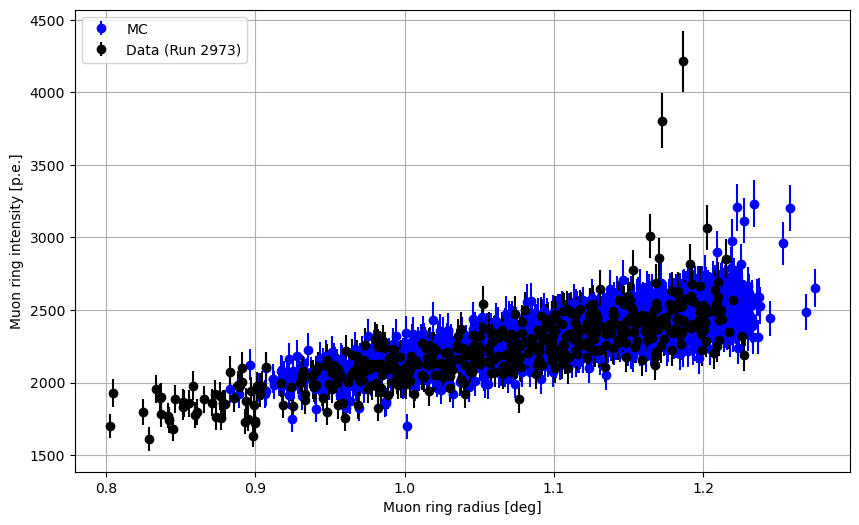

In [21]:

# Plotting
plt.figure(figsize=(10, 6))

# Plotting MC data
plt.errorbar(df_sim_data_globa_nsbtune['ring_radius'], df_sim_data_globa_nsbtune['ring_size'], 
             yerr=df_sim_data_globa_nsbtune['ring_size'] * 0.05, fmt='o', color='blue', label='MC')

# Plotting Data Run
plt.errorbar(df_real_data['ring_radius'], df_real_data['ring_size'], 
             yerr=df_real_data['ring_size'] * 0.05, fmt='o', color='black', label='Data (Run 2973)')

# Adding labels and legend
plt.xlabel('Muon ring radius [deg]')
plt.ylabel('Muon ring intensity [p.e.]')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
np.mean(df_real_data['ring_size'][(df_real_data['ring_radius'] > 0.94) & (df_real_data['ring_radius'] < 0.96)])

2021.1772

In [29]:
np.mean(df_sim_data_globa_nsbtune['ring_size'][(df_sim_data_globa_nsbtune['ring_radius'] > 0.94) & (df_sim_data_globa_nsbtune['ring_radius'] < 0.96)])

2047.6711

In [31]:
print(f"data {np.mean(df_real_data['ring_size'][(df_real_data['ring_radius'] > 1.01) & (df_real_data['ring_radius'] < 1.03)])}")
print(f"sim {np.mean(df_sim_data_globa_nsbtune['ring_size'][(df_sim_data_globa_nsbtune['ring_radius'] > 1.01) & (df_sim_data_globa_nsbtune['ring_radius'] < 1.03)])}")

data 2140.865966796875
sim 2175.73291015625


In [32]:
print(f"data {np.mean(df_real_data['ring_size'][(df_real_data['ring_radius'] > 1.06) & (df_real_data['ring_radius'] < 1.08)])}")
print(f"sim {np.mean(df_sim_data_globa_nsbtune['ring_size'][(df_sim_data_globa_nsbtune['ring_radius'] > 1.06) & (df_sim_data_globa_nsbtune['ring_radius'] < 1.08)])}")

data 2206.76025390625
sim 2261.851806640625


In [34]:
len(df_sim_data_globa_nsbtune['ring_size'][(df_sim_data_globa_nsbtune['ring_radius'] > 1.06) & (df_sim_data_globa_nsbtune['ring_radius'] < 1.08)])

129

In [35]:
len(df_real_data['ring_size'][(df_real_data['ring_radius'] > 1.06) & (df_real_data['ring_radius'] < 1.08)])

34

,event_id,event_time,mc_energy,ring_size,size_outside,ring_center_x,ring_center_y,ring_radius,ring_width,good_ring,...,impact_parameter,impact_x_array,impact_y_array,radial_stdev,radial_skewness,radial_excess_kurtosis,num_pixels_in_ring,mean_pixel_charge_around_ring,hg_peak_sample,lg_peak_sample
17870858,8302.0,1.704835e+09,-1.0,2097.0325,0.0,0.486513,-0.422342,0.968992,0.077523,True,...,4.915505,4.085945,2.732626,0.065626,-0.300866,0.258214,324.0,0.334639,10.0,0.0
17870861,12156.0,1.704835e+09,-1.0,2204.3489,0.0,0.187798,0.684892,1.088789,0.080941,True,...,4.455717,-4.430417,-0.474155,0.062574,-0.613731,0.571445,409.0,0.352234,7.0,0.0
17870866,15996.0,1.704835e+09,-1.0,2203.4626,0.0,0.311312,-0.576228,1.047281,0.077353,True,...,4.798895,2.879306,3.839139,0.063968,0.152482,0.453033,382.0,0.405524,8.0,0.0
17870899,48013.0,1.704835e+09,-1.0,1975.5323,0.0,0.215180,-0.608844,1.020200,0.092633,True,...,3.864170,-2.736391,-2.728365,0.066512,-0.015769,0.334459,364.0,0.210420,8.0,0.0
17870903,53560.0,1.704835e+09,-1.0,2484.4468,0.0,-0.537277,0.810036,1.178323,0.042861,True,...,3.923603,3.557109,-1.655789,0.042263,-0.008660,0.206939,452.0,0.469815,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20862432,1090785.0,1.709159e+09,-1.0,2406.6763,0.0,-0.988168,-0.283814,1.191860,0.049728,True,...,5.367115,-1.235806,-5.222902,0.047355,0.106607,0.240292,460.0,0.208937,13.0,0.0
20862439,1094336.0,1.709159e+09,-1.0,2400.7378,0.0,0.820682,0.539208,1.147433,0.051865,True,...,5.334225,4.426857,-2.976054,0.051266,-0.121486,0.794373,451.0,0.385975,13.0,0.0
20862457,1108506.0,1.709159e+09,-1.0,2510.8510,0.0,0.243643,0.507281,1.142727,0.049365,True,...,2.651393,2.211061,1.463247,0.046059,0.554639,0.972700,451.0,0.178549,13.0,0.0
20862472,1128961.0,1.709159e+09,-1.0,2384.9827,0.0,-0.711481,0.095503,1.150645,0.045607,True,...,5.036693,-0.241893,5.030881,0.044792,-0.150976,-0.035021,458.0,0.163360,14.0,0.0


(array([0.34455566, 0.7827867 , 1.38291201, 2.12461106, 2.91432014,
        3.58009636, 3.92375882, 3.74556347, 1.63602532, 0.0141797 ]),
 array([0.80000625, 0.84890885, 0.89781146, 0.94671406, 0.99561666,
        1.04451927, 1.09342187, 1.14232447, 1.19122707, 1.24012968,
        1.28903228]),
 <BarContainer object of 10 artists>)

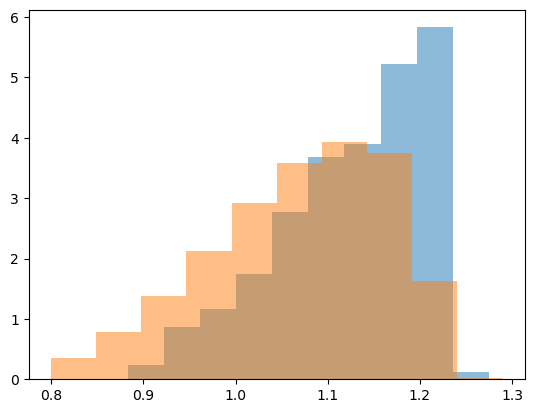

In [49]:
plt.hist(df_sim_data_globa_nsbtune['ring_radius'], alpha = 0.5, density=True)
plt.hist(df_real_data_cut['ring_radius'], alpha = 0.5, density=True)

,event_id,event_time,mc_energy,ring_size,size_outside,ring_center_x,ring_center_y,ring_radius,ring_width,good_ring,...,impact_parameter,impact_x_array,impact_y_array,radial_stdev,radial_skewness,radial_excess_kurtosis,num_pixels_in_ring,mean_pixel_charge_around_ring,hg_peak_sample,lg_peak_sample
17870858,8302.0,1.704835e+09,-1.0,2097.0325,0.0,0.486513,-0.422342,0.968992,0.077523,True,...,4.915505,4.085945,2.732626,0.065626,-0.300866,0.258214,324.0,0.334639,10.0,0.0
17870861,12156.0,1.704835e+09,-1.0,2204.3489,0.0,0.187798,0.684892,1.088789,0.080941,True,...,4.455717,-4.430417,-0.474155,0.062574,-0.613731,0.571445,409.0,0.352234,7.0,0.0
17870866,15996.0,1.704835e+09,-1.0,2203.4626,0.0,0.311312,-0.576228,1.047281,0.077353,True,...,4.798895,2.879306,3.839139,0.063968,0.152482,0.453033,382.0,0.405524,8.0,0.0
17870899,48013.0,1.704835e+09,-1.0,1975.5323,0.0,0.215180,-0.608844,1.020200,0.092633,True,...,3.864170,-2.736391,-2.728365,0.066512,-0.015769,0.334459,364.0,0.210420,8.0,0.0
17870903,53560.0,1.704835e+09,-1.0,2484.4468,0.0,-0.537277,0.810036,1.178323,0.042861,True,...,3.923603,3.557109,-1.655789,0.042263,-0.008660,0.206939,452.0,0.469815,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20862432,1090785.0,1.709159e+09,-1.0,2406.6763,0.0,-0.988168,-0.283814,1.191860,0.049728,True,...,5.367115,-1.235806,-5.222902,0.047355,0.106607,0.240292,460.0,0.208937,13.0,0.0
20862439,1094336.0,1.709159e+09,-1.0,2400.7378,0.0,0.820682,0.539208,1.147433,0.051865,True,...,5.334225,4.426857,-2.976054,0.051266,-0.121486,0.794373,451.0,0.385975,13.0,0.0
20862457,1108506.0,1.709159e+09,-1.0,2510.8510,0.0,0.243643,0.507281,1.142727,0.049365,True,...,2.651393,2.211061,1.463247,0.046059,0.554639,0.972700,451.0,0.178549,13.0,0.0
20862472,1128961.0,1.709159e+09,-1.0,2384.9827,0.0,-0.711481,0.095503,1.150645,0.045607,True,...,5.036693,-0.241893,5.030881,0.044792,-0.150976,-0.035021,458.0,0.163360,14.0,0.0


(array([2.29340094, 2.90819377, 3.4569293 , 3.9534043 , 4.24021007,
        4.52492542, 4.5585812 , 4.16516396, 2.89732359, 0.35788008]),
 array([0.95000608, 0.97998568, 1.00996529, 1.03994489, 1.06992449,
        1.09990409, 1.1298837 , 1.1598633 , 1.1898429 , 1.2198225 ,
        1.24980211]),
 [<matplotlib.patches.Polygon at 0x39fb98fd0>])

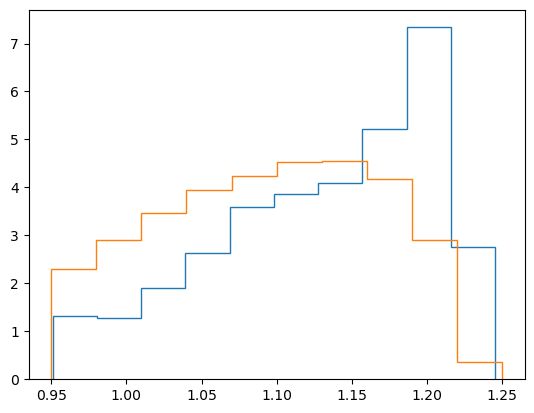

In [60]:
plt.hist(df_sim_cut['ring_radius'], alpha = 1, density=True, histtype='step', bins = 10)
plt.hist(df_real_cut['ring_radius'], alpha = 1, density=True, histtype='step', bins = 10)

In [64]:
max(df_sim_cut['ring_radius'])

1.2451408710915557

In [63]:
max(df_real_cut['ring_radius'])

1.2498021061408917